# Customer Segmentation & Retention Strategy using Transactional Data



This project demonstrates an end-to-end customer segmentation and retention strategy built on transactional data. The objective is to identify high-value and high-risk customer segments, quantify churn risk, and support data-driven retention decisions through interpretable models, deployment, and monitoring.

## Dataset

This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers.

Dataset Source : - https://archive-beta.ics.uci.edu/dataset/502/online+retail+ii

The dataset contains 1067371 entries and has 8 columns. This is a short description of the columns:

- Invoice   : Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode : Product (item) code.  A 5-digit integral number uniquely assigned to each distinct product.
- Description   : Product (item) name. 
- Quantity  : The quantities of each product (item) per transaction. 
- InvoiceDate   : Invoice date and time. The day and time when a transaction was generated.
- Price : Unit price.  Product price per unit in sterling (£).
- CustomerID    : Customer number. A 5-digit integral number uniquely assigned to each customer.
- Country   : Country name. The name of the country where a customer resides.


## Importing Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Dataset

We have imported the excel dataset into a pandas DataFrame. 

In [3]:
df = pd.concat(pd.read_excel("online_retail_II.xlsx", sheet_name=None).values())

Below are the top most 5 records of the dataset. 

In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Summary Statistics

Lets just see some of the basic statistics of the dataset 

In [5]:
df.shape

(1067371, 8)

In [6]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='str')

In [7]:
df.info()

<class 'pandas.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[us]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  str           
dtypes: datetime64[us](1), float64(2), int64(1), object(3), str(1)
memory usage: 73.3+ MB


Dataset is having null values as expected 

In [8]:
df[["Quantity", "Price"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1067371.0,9.938898,172.705794,-80995.00,1.00,3.0,10.00,80995.0
Price,1067371.0,4.649388,123.553059,-53594.36,1.25,2.1,4.15,38970.0


Calling the method describe of the Pandas dataframe shows some summary statistics, such as mean, median, quartiles etcs , for the numerical columns Quantity and Price. This shows that both columns have negative values which doesn't make sense, you cannot buy less than 0 items and/or for a negative price.

In [9]:
df.duplicated().sum()

np.int64(34335)

Even the dataset is having duplicate records which need to be handled. 

## Exploratory Data Analysis

Let's explore the data then we shall move to cleaning and preprocessing the Data. 

In [10]:
df["Country"].nunique()

43

There are 43 unique countries in the dataset.

In [11]:
print(df["Country"].unique().tolist())

['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE', 'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria', 'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy', 'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden', 'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified', 'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore', 'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon', 'Korea', 'Brazil', 'Canada', 'Iceland', 'Saudi Arabia', 'Czech Republic', 'European Community']


Let's see the percentage of transactions in each country. 

In [12]:
(df["Country"].value_counts(normalize=True).head(10).map(lambda x: f"{x*100:.2f} %"))


Country
United Kingdom    91.94 %
EIRE               1.67 %
Germany            1.65 %
France             1.34 %
Netherlands        0.48 %
Spain              0.36 %
Switzerland        0.30 %
Belgium            0.29 %
Portugal           0.25 %
Australia          0.18 %
Name: proportion, dtype: str

Most of the transaction is from United Kingdom which is around 91 % and other transactions are mostly made by the neighboring countries like Ireland, Germany and France. 

Let's see the transaction period. 

In [13]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"Data ranges from {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")


Data ranges from 2009-12-01 07:45:00 to 2011-12-09 12:50:00


In [14]:

print(f"Number of transactions registered: {df['Invoice'].nunique()}")

Number of transactions registered: 53628


In [15]:

print(f"Number of Unique Products sold : {df['StockCode'].nunique()}")

Number of Unique Products sold : 5305


In [16]:
print(f"Number of Unique Customers : {df['Customer ID'].nunique()}")

Number of Unique Customers : 5942


Lets see how was the sales in each Month and Monthly Active Customers, then try to answer below questions. 

    - How many active customers per month? 
    - Is customer activity increasing, stable, or declining? 
    - Are there seasonal patterns in purchases? 
    - Do we see spikes due to holidays or promotions?

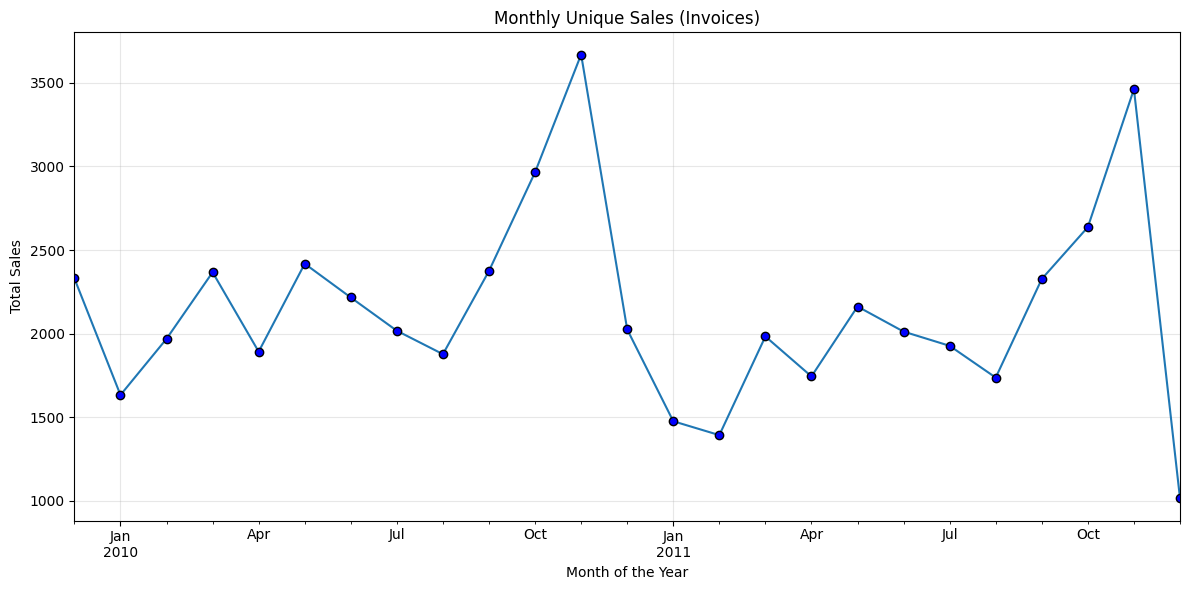

In [17]:
ax = (df.set_index("InvoiceDate").resample("ME")["Invoice"].nunique().plot(figsize=(12, 6),marker="o",linestyle="-",markerfacecolor="blue",markeredgecolor="black"))


ax.set_xlabel("Month of the Year")
ax.set_ylabel("Total Sales")
ax.set_title("Monthly Unique Sales (Invoices)")


ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../assets/Monthly Unique Sales (Invoices).png") 
plt.show()


As expected there is huge increase in transaction during the september to december for both years. Major events like Halloween and Christmas are during that time. 

Let's check the customer activity now. 

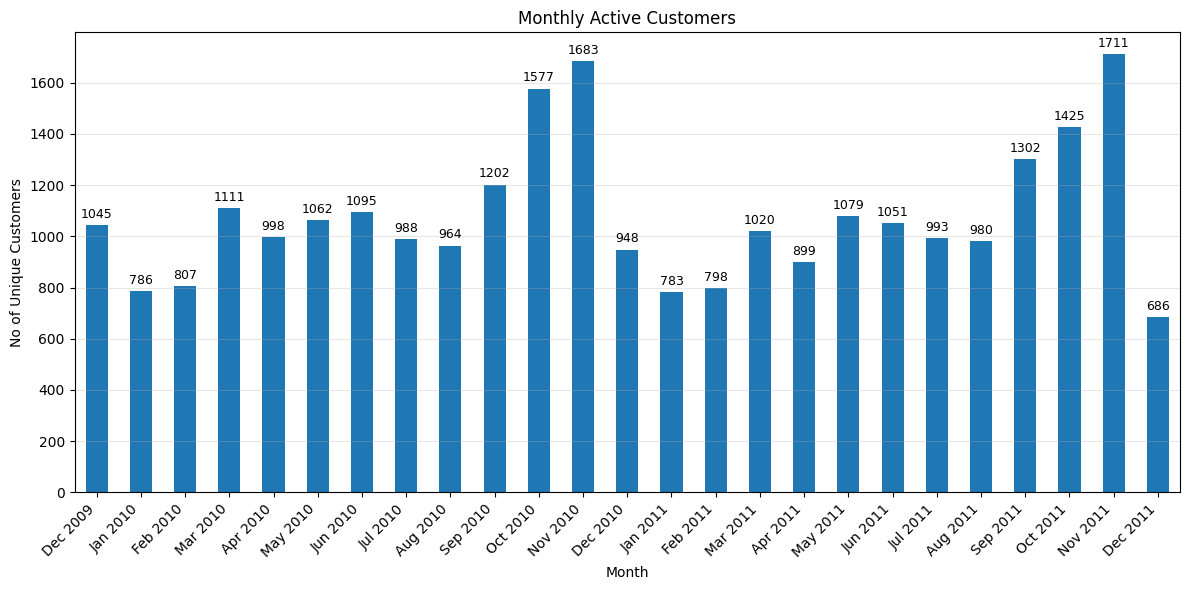

In [18]:
monthly_active = (
    df.set_index("InvoiceDate")
      .resample("ME")["Customer ID"]
      .nunique()
)

ax = monthly_active.plot(kind="bar", figsize=(12, 6))

ax.set_xlabel("Month")
ax.set_ylabel("No of Unique Customers")
ax.set_title("Monthly Active Customers")
ax.grid(axis="y", alpha=0.3)


ax.set_xticklabels(
    monthly_active.index.strftime("%b %Y"),
    rotation=45,
    ha="right"
)

# Add values on top
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=9,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.tight_layout()
plt.savefig("../assets/Monthly Active Customers.png") 
plt.show()

We can see the almost similar patterns in both plots. Customer activity and the sales are increasing september to december for both years. Major events like Halloween and Christmas are during that time. We are seeing the spikes due to holidays. 

### Missing values in Dataset 

Let's check the missing and invalid values


In [19]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

#### Description 

There are 243007 null values as Customer ID and 4382 null values in description. Let first go through the null values in description column. 

In [20]:
print(f"Percentage of missing values in Description: {df['Description'].isnull().mean() * 100:.2f}%")

Percentage of missing values in Description: 0.41%


Percentage of missing values in the description column in 0.41 %. Another column with null values is Customer ID. We need to check whether the all column where description is null the customer ID also is null. Let see some sample of where description is null. 

In [21]:
df[df['Description'].isnull()].sample(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
362043,568404,22497,NaN,-17,2011-09-27 10:36:00,0.0,NaN,United Kingdom
436903,531144,17178,NaN,-4,2010-11-05 14:12:00,0.0,NaN,United Kingdom
82264,496939,72140D,NaN,-6,2010-02-04 17:20:00,0.0,NaN,United Kingdom
66450,495321,21490,NaN,-16,2010-01-22 15:41:00,0.0,NaN,United Kingdom
428293,530317,35969,NaN,-52,2010-11-02 13:32:00,0.0,NaN,United Kingdom
82267,496941,84427B,NaN,-6,2010-02-04 17:22:00,0.0,NaN,United Kingdom
331517,521783,22087,NaN,-67,2010-09-08 12:43:00,0.0,NaN,United Kingdom
82827,496986,84845B,NaN,-8,2010-02-05 11:20:00,0.0,NaN,United Kingdom
118221,500675,16156N,NaN,-200,2010-03-09 12:27:00,0.0,NaN,United Kingdom
50808,540560,21589,NaN,-14,2011-01-10 10:08:00,0.0,NaN,United Kingdom


Seeing this samples there is high chance that both are null. Let's check it 

In [22]:
all(df[df["Description"].isnull()]["Customer ID"].isnull())

True

In [23]:
(df[df["Description"].isnull()]["Quantity"] <= 0).mean() * 100

np.float64(61.364673664993155)

In [24]:
df[(df["Description"].isnull()) & (df["Country"] == "United Kingdom")].shape[0]

4382

In [25]:
all(df[df["Description"].isnull()]["Country"] == "United Kingdom")

True

In [26]:
df[(df["Description"].isnull()) & (df["Price"] == 0.0)].shape[0]

4382

In [27]:
all(df[df["Description"].isnull()]["Price"] == 0.0)

True

All records where the description is null in the same record price is 0.0 , quantity is negative and country of transaction is United Kingdom. This might be due returns, cancellation and refunds. This needs to be explored later. 

#### Customer ID

Let's now check the null values in Customer ID. 

In [28]:
print(f"Percentage of missing values in Customer ID: {df['Customer ID'].isnull().mean() * 100:.2f}%")

Percentage of missing values in Customer ID: 22.77%


Percentage of missing values in the description column in 22.77 %. This is lot more than that we had in description column. 

In [29]:
df[df['Customer ID'].isnull()].sample(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
193999,507864,21691,NaN,-34,2010-05-11 14:56:00,0.00,NaN,United Kingdom
86447,543546,82613B,"METAL SIGN,CUPCAKE SINGLE HOOK",1,2011-02-09 16:52:00,2.46,NaN,United Kingdom
521417,537823,84970L,SINGLE HEART ZINC T-LIGHT HOLDER,1,2010-12-08 14:25:00,2.13,NaN,United Kingdom
93249,498133,84762A,WHITE PICNIC BARBECUE BUCKET,1,2010-02-16 17:24:00,8.47,NaN,United Kingdom
449745,575138,23148,MINIATURE ANTIQUE ROSE HOOK IVORY,1,2011-11-08 15:24:00,2.46,NaN,United Kingdom
80744,496800,21523,DOOR MAT FANCY FONT HOME SWEET HOME,1,2010-02-03 17:04:00,13.57,NaN,United Kingdom
328958,565840,21988,PACK OF 6 SKULL PAPER PLATES,2,2011-09-07 12:02:00,1.63,NaN,United Kingdom
363650,568567,20829,GLITTER HANGING BUTTERFLY STRING,2,2011-09-27 18:41:00,4.13,NaN,United Kingdom
301735,518774,15034,PAPER POCKET TRAVELING FAN,3,2010-08-11 15:40:00,0.85,NaN,United Kingdom
57064,541130,22898,CHILDRENS APRON APPLES DESIGN,1,2011-01-14 10:15:00,4.13,NaN,United Kingdom


In [30]:
all(df[df["Customer ID"].isnull()]["Description"].isnull())

False

In [31]:
df[df["Customer ID"].isnull()]["Description"].nunique()

4872

In [32]:
(df[df["Customer ID"].isnull()]["Quantity"] <= 0).mean() * 100

np.float64(1.7308143386816017)

In [33]:
df[(df["Customer ID"].isnull()) & (df["Price"] == 0.0)].shape[0]

6131

In [34]:
(df[df["Customer ID"].isnull()]["Price"] == 0.0).mean() *100

np.float64(2.522972589266976)

In [35]:
df[(df["Customer ID"].isnull()) & (df["Country"] == "United Kingdom")].shape[0]

240029

In [36]:
print (f"Percentage of missing Customer IDs in United Kingdom: {df[(df['Customer ID'].isnull()) & (df['Country'] == 'United Kingdom')].shape[0] / (df['Customer ID'].isnull().sum())*100:.2f}%")

Percentage of missing Customer IDs in United Kingdom: 98.77%


We didn't identify any clear pattens with the null values in Customer ID. As it is scattered and some are having price is 0.0 and quantity is negative. Since the majority of transaction is from United Kingdom. United Kingdom has contributed 98.77 % of null value. 

#### Price and Quantity 

Let's now check the prices and quantity. There were prices with 0.0 and quantity with negative values. 

In [37]:
(df["Price"] <= 0).mean() * 100

np.float64(0.5815222635803297)

In [38]:
(df["Price"] <= 0).sum()

np.int64(6207)

In [39]:
(df["Quantity"] <= 0).mean() * 100

np.float64(2.1501427338760375)

In [40]:
(df["Quantity"] <= 0).sum()

np.int64(22950)

There are 6207 records where price is less than 0 and 22950 records where quantity is less than 0 or 0. Let's see the sample data where quantity is less than 0 or 0. 

In [41]:

df[df["Quantity"] <= 0].sample(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
18396,C490942,21481,FAWN BLUE HOT WATER BOTTLE,-6,2009-12-08 14:04:00,2.95,14337.0,United Kingdom
71069,C495789,ADJUST,Adjustment by john on 26/01/2010 17,-1,2010-01-26 17:17:00,503.19,NaN,United Kingdom
326694,C521231,90001B,ANTIQUE MID BLUE FLOWER EARRINGS,-1,2010-09-03 11:11:00,4.25,NaN,United Kingdom
383054,C569994,21479,WHITE SKULL HOT WATER BOTTLE,-18,2011-10-06 20:33:00,3.39,15606.0,United Kingdom
468960,C576561,21929,JUMBO BAG PINK VINTAGE PAISLEY,-1,2011-11-15 13:22:00,1.79,15311.0,United Kingdom
446627,C531873,21735,TWO DOOR CURIO CABINET,-4,2010-11-10 11:39:00,10.95,17340.0,United Kingdom
324551,C521016,22488,NATURAL SLATE RECTANGLE CHALKBOARD,-3,2010-09-01 14:58:00,1.65,15240.0,United Kingdom
379577,C525956,22065,CHRISTMAS PUDDING TRINKET POT,-7,2010-10-07 19:29:00,1.45,13320.0,United Kingdom
487789,C577779,23055,IVORY CHANDELIER T-LIGHT HOLDER,-96,2011-11-21 16:11:00,1.00,NaN,United Kingdom
265294,560214,16162L,NaN,-54,2011-07-15 15:07:00,0.00,NaN,United Kingdom


Exploring the sample we shall notice that some of the invoices are starting with "C". That indicates some cancellation has happened or invoice has been cancelled. Lets check what percentage of invoice starts with C against the total number of records where the quantity is less than 0 or 0. 

In [42]:

print(f"Percentage of negative quantity values that start with 'C': {df[df['Quantity'] <= 0]['Invoice'].astype('str').str.startswith('C').mean() * 100:.2f}%")

Percentage of negative quantity values that start with 'C': 84.94%


In [43]:

(df[df["Invoice"].astype("str").str.startswith("C")]["Quantity"] <= 0.).mean() * 100

np.float64(99.99487021647685)

So its clear 99 % of invoice starting with C is having quantity 0 or negative. 

# Data Cleaning & Transformation

### Handling Missing Values

In [44]:
missing_data = df.isnull().sum()
missing_data

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [45]:
missing_data_percent = missing_data[missing_data>0] / df.shape[0] *100
missing_data_percent


Description     0.410541
Customer ID    22.766873
dtype: float64

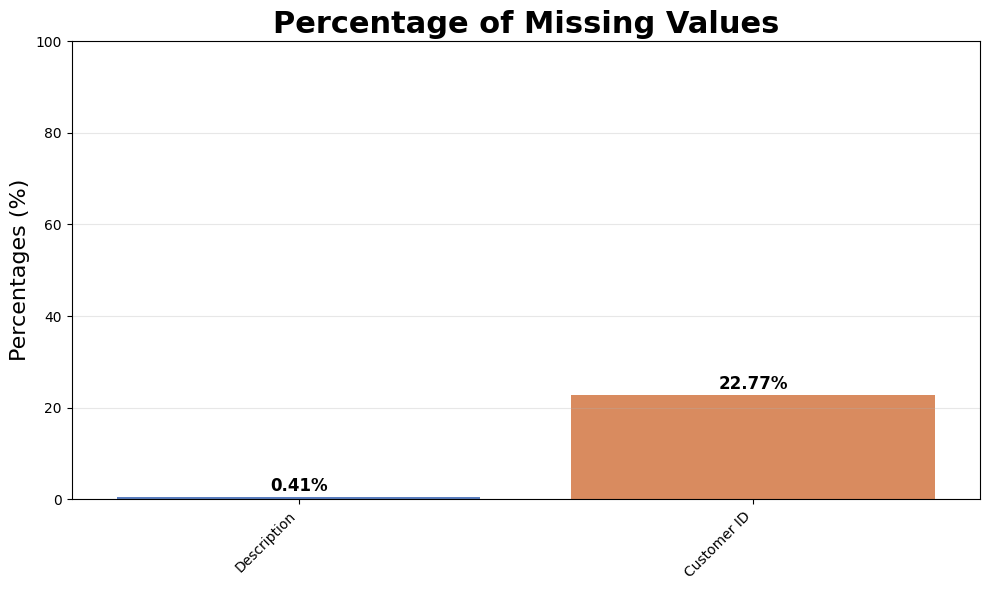

In [46]:
missing_data_percent = missing_data_percent.sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(x=missing_data_percent.index, y=missing_data_percent.values, hue=missing_data_percent.index,palette="muted",legend=False,ax=ax)



for i, value in enumerate(missing_data_percent.values):
    ax.text(i,value + 0.5,f"{value:.2f}%",ha="center",va="bottom",fontsize=12,fontweight="bold",color="black")

ax.set_ylim(0, 100)
ax.set_title("Percentage of Missing Values", fontsize=22, fontweight="bold")
ax.set_ylabel("Percentages (%)", fontsize=16)
ax.set_xlabel("")


plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("../assets/Percentage of Missing Values.png") 
plt.show()


Customer ID is having almost 25% of missing values. Its not recommended to impute such a large percentage of  missing values this might cause bias or noise to the analysis. Customer segmentation is purely based on customer behavior and preference. So it is very important to have an accurate data. Description is having very negligible amount of missing values. Since it is a low impact categorical features, we have two options: Can drop this as the impact is less or can impute as "Unknown" and can be used as categorical feature. In this case i am imputing as "Unknown" for description and drop the Customer ID. 

In [47]:
df["Description"] = df["Description"].fillna("Unknown")
df = df.dropna(subset=['Customer ID'])

In [48]:
df.isnull().sum().sum()

np.int64(0)

In [49]:
df.shape

(824364, 8)

## Handling Duplicates 

In [50]:
df.duplicated().sum()

np.int64(26479)

we have 26479 duplicate rows. Since the accuracy of the Data is important for the prediction. It is important to remove these duplicates other it will result unwanted noise in the dataset. Removing these rows will help in achieving a cleaner dataset. 

In [51]:
df.drop_duplicates(inplace=True)

In [52]:
df.shape

(797885, 8)

### Treating Cancelled Transactions

In [53]:
df['Transaction_Status'] = np.where(df['Invoice'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop(['Customer ID','InvoiceDate'], axis=1)

,Quantity,Price
count,18390.000000,18390.000000
mean,-25.719195,24.240567
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000
std,825.979381,428.241509


In [54]:
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

In [55]:
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.30%


All the quantity values that are negative correspond to cancelled transactions. The item value range from 0.01 to 38970 which indicate that the all items from low to high were cancelled. So it is recommended to retain this data as there will be some patterns and trends in cancellation that will be helpful in identifying the customer behavior. 

### Correcting StockCode Anomalies

In [56]:
unique_stock_codes = df['StockCode'].nunique()
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 4646


In [57]:
top_10_stock_codes = df["StockCode"].value_counts(normalize=True).head(10)
print(f"The top 10 most frequent stock codes are: {top_10_stock_codes}")

The top 10 most frequent stock codes are: StockCode
85123A    0.006462
22423     0.004610
85099B    0.004236
84879     0.003395
20725     0.003366
21212     0.003236
21232     0.002660
47566     0.002658
20727     0.002618
22383     0.002594
Name: proportion, dtype: float64


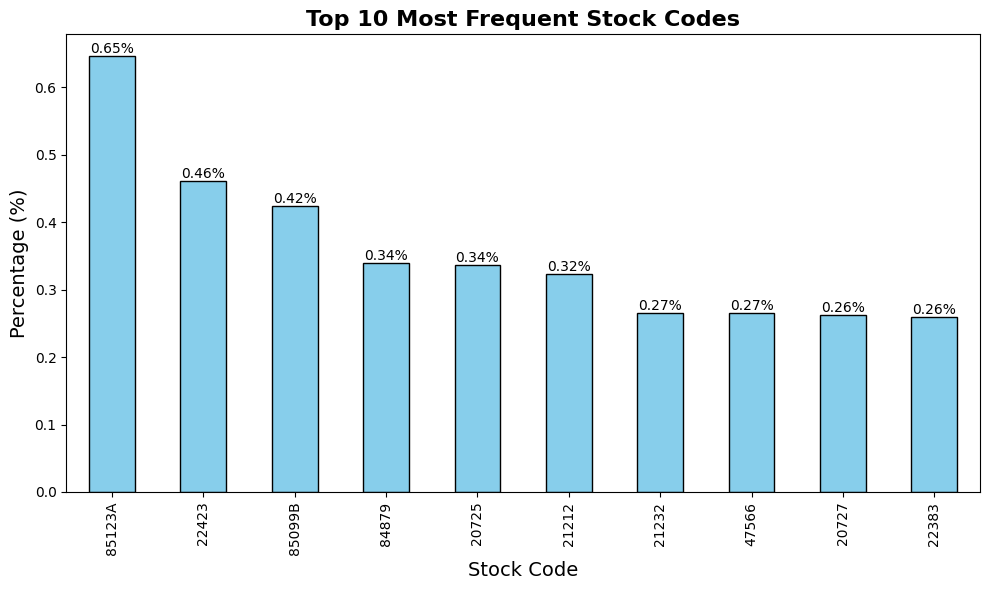

In [58]:
plt.figure(figsize=(10, 6))
ax = (top_10_stock_codes * 100).plot(kind='bar',color='skyblue',edgecolor='black')
ax.set_title('Top 10 Most Frequent Stock Codes', fontsize=16, fontweight='bold')
ax.set_xlabel('Stock Code', fontsize=14)        
ax.set_ylabel('Percentage (%)', fontsize=14)


for i, val in enumerate(top_10_stock_codes * 100):
    ax.text(i, val, f"{val:.2f}%", ha='center', va='bottom')

plt.tight_layout()
fig.savefig("../assets/Top 10 Most Frequent Stock Codes.png")
plt.show()

The dataset is having 4646 unique stock code that is showing that the there is different range of products in the dataset. This will be used to understand the behavior of the customer. Exploring the top 10 frequent stock code will help to customer purchase frequency. Let's check if there is any anomaly in stock code. 

In [59]:
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()


print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    4633
0       8
1       2
3       2
4       1
Name: count, dtype: int64


We have just checked the numeric characters in the stock code and we found that the 4633 codes is having 5 numeric values and others are not in that pattern. Need to check which are those to confirm whether it is an anomaly or not. 

In [60]:
anomalous_stock_codes  = [ code for code in unique_stock_codes if sum(c.isdigit() for c in str(code))<=4]

print("Anomalous stock codes:")
print("-"*22)

for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
M
C2
BANK CHARGES
TEST001
TEST002
PADS
ADJUST
ADJUST2
SP1002
DOT
CRUK


In [61]:
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df) * 100)
print(f"Percentage of anomalous stock codes: {percentage_anomalous:.2f}%")

Percentage of anomalous stock codes: 0.46%


Total percentage of stock codes which are anomalous are 0.46 % which is very less compared to dataset. Only 13 out of 4646 unique stock code are deviating from the format. These are some Bank Charges, Post, Test etc which does not represent the actual data and this does not seem to be related to product purchase and need to be removed. 


In [62]:
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [63]:
df.shape[0]

794223

### Cleaning Description Column

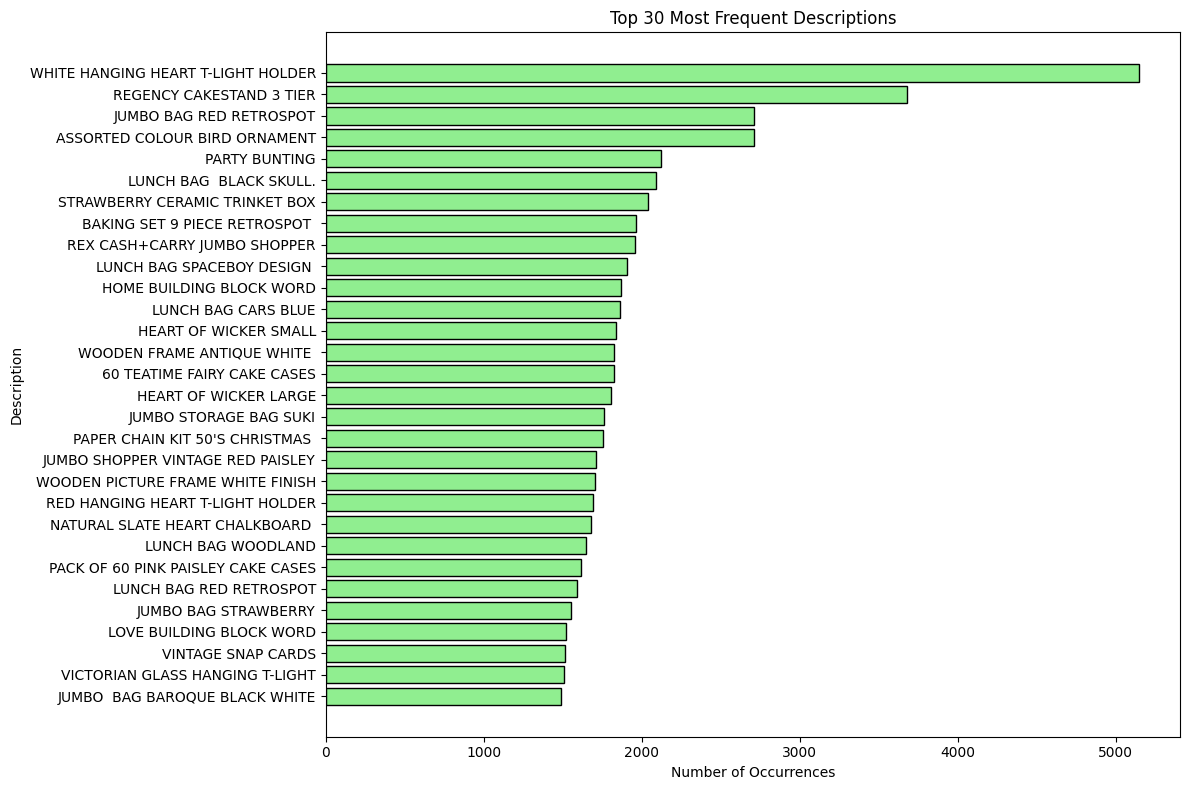

In [64]:
description_counts = df['Description'].value_counts()

top_30_descriptions = description_counts[:30]

plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='lightgreen', edgecolor='black')


plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

plt.tight_layout()
fig.savefig("../assets/Top 30 Most Frequent Descriptions.png")
plt.show()


The top 30 most frequent descriptions are household items, kitchenware, lunch bags, and decorative items. We can see these descriptions are in upper case. So it should be standard to mention in upper case. Let's check whether any description is in lower case. 

In [65]:
lowercase_descriptions = [desc for desc in df['Description'].unique() if any (char.islower() for char in str(desc))]

print("The unique descriptions containing lowercase characters are:")
print("-"*60)

for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 40x40cm
POLYESTER FILLER PAD 60x40cm
POLYESTER FILLER PAD 65CMx65CM
POLYESTER FILLER PAD 45x45cm
BAG 125g SWIRLY MARBLES
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
FOLK ART GREETING CARD,pack/12
BAG 250g SWIRLY MARBLES
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 45x30cm
 SET Of 6 SOLDIER SKITTLES
THE KING GIFT BAG 25x24x12cm
FRENCH BLUE METAL DOOR SIGN, No
NUMBER TILE COTTAGE GARDEN, No
NUMBER TILE VINTAGE FONT, No 
NUMBER TILE VINTAGE FONT No 
FRENCH BLUE METAL DOOR SIGN No
NUMBER TILE COTTAGE GARDEN No
3 TRADITIONAl BISCUIT CUTTERS  SET
FLOWERS HANDBAG blue and orange
Next Day Carriage
High Resolution Image


Going through these descriptions containing lowercase characters, its clear that there are 2 service related description "Next Day Carriage" and "High Resolution Image". This need to be removed as this will only create noise in the model. Remaining description need to standardized to upper case in order to make sure the description follow a standard format. 

In [66]:
service_related_descriptions = ['Next Day Carriage', 'High Resolution Image']

service_related_description_percentage = (df['Description'].isin(service_related_descriptions).sum() / len(df)) * 100
print(f"Percentage of service-related descriptions: {service_related_description_percentage:.2f}%")

Percentage of service-related descriptions: 0.01%


In [67]:
df = df[~df['Description'].isin(service_related_descriptions)]

df['Description'] = df['Description'].str.upper()

df.shape[0]

794140

### Treating Zero Unit Prices

In [68]:
df[df['Price']==0].value_counts().sum()


np.int64(60)

In [69]:
df['Price'].describe()

count    794140.000000
mean          2.969938
std           4.473401
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: Price, dtype: float64

We can see that there are 60 records where the price is 0. This might be a typo error or free item. Need to explore more to identify the pattern. 

In [70]:
df[df['Price']==0].describe()[['Quantity']]

,Quantity
count,60.000000
mean,245.583333
min,1.000000
25%,2.000000
50%,7.000000
75%,21.000000
max,12540.000000
std,1616.970743


In these transactions the quantity ranges from 1 to 12540. Including these 60 records will create more noise and will be effecting our model. So we need to remove this to make the dataset more cleaner. 

In [71]:
df = df[df['Price']>0]


In [72]:
df.reset_index(drop=True, inplace=True)

In [73]:
df.shape[0]

794080

## Feature Engineering 

### RFM Features

In [74]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Transaction_Status'],
      dtype='str')

In [75]:
from scipy.stats import linregress

def feature_engineering(df, churn_days=90):


    df = df.copy()
    

    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    

    df['Total_Spend'] = df['Quantity'] * df['Price']
    

    snapshot_date = df['InvoiceDate'].max()
    

    rfm = df.groupby('Customer ID').agg(Recency=('InvoiceDate', lambda x: (snapshot_date - x.max()).days),
                                        Frequency=('Invoice', 'nunique'),
                                        Monetary=('Total_Spend', 'sum'),
                                        Total_Products_Purchased=('Quantity', 'sum'),
                                        Unique_Products_Purchased=('StockCode', 'nunique'),
                                        First_Purchase=('InvoiceDate', 'min'),
                                        Last_Purchase=('InvoiceDate', 'max')).reset_index()
    

    rfm['Avg_Transaction_Value'] = rfm['Monetary'] / rfm['Frequency']
    

    rfm['Customer_Tenure_Days'] = (snapshot_date - rfm['First_Purchase']).dt.days
    

    

    purchase_gaps = df.sort_values(['Customer ID', 'InvoiceDate']).groupby('Customer ID')['InvoiceDate'].diff().dt.days
    gap_stats = purchase_gaps.groupby(df['Customer ID']).agg( Avg_Days_Between_Purchases='mean',Std_Days_Between_Purchases='std' ).reset_index()
    gap_stats['Std_Days_Between_Purchases'] = gap_stats['Std_Days_Between_Purchases'].fillna(0)
    

    gap_stats['Purchase_Regularity'] = (gap_stats['Avg_Days_Between_Purchases'] / (gap_stats['Std_Days_Between_Purchases'] + 1)).fillna(0)
    

    monthly = df.assign(YearMonth=df['InvoiceDate'].dt.to_period('M')).groupby(['Customer ID', 'YearMonth'])['Total_Spend'].sum().reset_index()
    

    def calc_slope(s):
        return 0 if len(s) <= 1 else linregress(np.arange(len(s)), s.values).slope
    
    trend = monthly.groupby('Customer ID')['Total_Spend'].apply(calc_slope).reset_index(name='Spending_Trend')
    

    monthly_stats = monthly.groupby('Customer ID')['Total_Spend'].agg(Monthly_Spending_Mean='mean', Monthly_Spending_Std='std').reset_index()
    monthly_stats['Monthly_Spending_Std'] = monthly_stats['Monthly_Spending_Std'].fillna(0)
    

    rfm['Revenue_Per_Product'] = (rfm['Monetary'] / rfm['Unique_Products_Purchased']).fillna(0)
    

    total_tx = df.groupby('Customer ID')['Invoice'].nunique().reset_index(name='Total_Transactions')
    cancelled = df[df['Transaction_Status']=='Cancelled'].groupby('Customer ID')['Invoice'].nunique().reset_index(name='Cancelled_Transactions')
    cancel_features = total_tx.merge(cancelled, on='Customer ID', how='left')
    cancel_features['Cancelled_Transactions'] = cancel_features['Cancelled_Transactions'].fillna(0)
    cancel_features['Cancellation_Rate'] = cancel_features['Cancelled_Transactions'] / cancel_features['Total_Transactions']
    

    country_mode = df.groupby(['Customer ID','Country']).size().reset_index(name='Count').sort_values('Count', ascending=False).drop_duplicates('Customer ID')
    country_mode['Is_UK'] = (country_mode['Country'] == 'United Kingdom').astype(int)
    

    rfm['Churn'] = (rfm['Recency'] > churn_days).astype(int)
    

    customer_data = rfm.merge(gap_stats[['Customer ID','Avg_Days_Between_Purchases','Std_Days_Between_Purchases','Purchase_Regularity']], on='Customer ID', how='left')
    customer_data = customer_data.merge(trend, on='Customer ID', how='left')
    customer_data = customer_data.merge(monthly_stats, on='Customer ID', how='left')
    customer_data = customer_data.merge(cancel_features[['Customer ID','Cancellation_Rate']], on='Customer ID', how='left')
    customer_data = customer_data.merge(country_mode[['Customer ID','Is_UK']], on='Customer ID', how='left')

    customer_data['Revenue_Percentile'] = pd.qcut(customer_data['Monetary'], 
                                               q=10, 
                                               labels=['0-10%', '10-20%', '20-30%', '30-40%', '40-50%',
                                                      '50-60%', '60-70%', '70-80%', '80-90%', '90-100%'],
                                               duplicates='drop')
    

    customer_data['R_Score'] = pd.qcut(customer_data['Recency'], 
                                    q=5, labels=[5,4,3,2,1], duplicates='drop')
    customer_data['R_Score'] = customer_data['R_Score'].astype(int)


    customer_data['F_Score'] = pd.qcut(customer_data['Frequency'].rank(method='first'), 
                                        q=5, labels=[1,2,3,4,5], duplicates='drop')
    customer_data['F_Score'] = customer_data['F_Score'].astype(int)


    customer_data['M_Score'] = pd.qcut(customer_data['Monetary'], 
                                        q=5, labels=[1,2,3,4,5], duplicates='drop')
    customer_data['M_Score'] = customer_data['M_Score'].astype(int)

    def get_rfm_segment(r, f, m):
        if r >= 4 and f >= 4:
            return 'Champions'
        elif r >= 4 and f >= 3:
            return 'Loyal Customers'
        elif r >= 3 and f >= 4:
            return 'Best Customers'
        elif r >= 3 and f >= 3:
            return 'Good Customers'
        elif r >= 4 and m >= 4:
            return 'At Risk - Big Spenders'
        elif r <= 2 and f >= 4:
            return 'Cant Lose Them'
        elif r <= 2 and m >= 4:
            return 'Lost - Big Spenders'
        elif r <= 2:
            return 'Lost Customers'
        elif f <= 2 and r <= 3:
            return 'Hibernating'
        elif m <= 2:
            return 'Low-Value Customers'
        else:
            return 'Potential'


    customer_data['RFM_Segment'] = customer_data.apply(lambda x: get_rfm_segment(x['R_Score'], x['F_Score'], x['M_Score']), axis=1)

    

    customer_data.fillna(0, inplace=True)
    
    return customer_data


This feature engineering pipeline is designed for advanced exploratory data analysis with a strong business focus on customer segmentation, churn risk, and retention strategy. A customer is considered churned if they have not made a purchase for more than  90 days since their last transaction. The goal of the churn model is not just prediction accuracy, but to identify high-value customers who are at risk early enough for intervention. Churn for model prediction is defined as no purchase within 90 days after a fixed snapshot date, where the snapshot date is set 180 days before the maximum date in the dataset.This separation ensures no data leakage and reflects real-world deployment conditions.


- RFM (Recency, Frequency, Monetary) features

    Recency, Frequency, Monetary, Total_Products_Purchased, Unique_Products_Purchased, First_Purchase, Last_Purchase, Avg_Transaction_Value and Customer_Tenure_Days was created to explore the RFM features of the customer. These features form the transactional foundation for customer segmentation and lifetime value analysis.

- Behavioral Features features

    Average & Std days between purchases,  Purchase regularity, Monthly spending trend, Spending trend (slope), Monthly mean & std and Revenue per product was created to explore the behavioral Features of the customer. These features help distinguish stable loyal customers from early churn risks, even when RFM values are similar.

- Cancellation behavior   

    Cancelled_Transactions and Cancellation_Rate was created to explore the customer reliability and friction.  These features provide additional signals for churn risk and customer quality.


- Geography

    Geographic features were engineered to capture regional purchasing behavior, including Primary customer location and Domestic vs international indicator

- Churn

    A churn label was created for exploratory analysis to Understand churn distribution across segments, Identify high-value at-risk customers and Support retention strategy design

- Other Features 

    Other Features was created for exploring the RFM (Recency, Frequency, Monetary) and revenue. 

In [76]:
customer_data = feature_engineering(df)
customer_data.head()

,Customer ID,Recency,Frequency,Monetary,Total_Products_Purchased,Unique_Products_Purchased,First_Purchase,Last_Purchase,Avg_Transaction_Value,Customer_Tenure_Days,...,Spending_Trend,Monthly_Spending_Mean,Monthly_Spending_Std,Cancellation_Rate,Is_UK,Revenue_Percentile,R_Score,F_Score,M_Score,RFM_Segment
0,12346.0,325,4,169.36,24,25,2010-03-02 13:08:00,2011-01-18 10:17:00,42.34000,646,...,-13.525000,56.453333,75.574143,0.25,1,10-20%,2,3,1,Lost Customers
1,12347.0,1,8,4921.53,2967,126,2010-10-31 14:20:00,2011-12-07 15:52:00,615.19125,403,...,3.339405,615.191250,315.773658,0.00,0,80-90%,5,4,5,Champions
2,12348.0,74,5,1658.40,2704,24,2010-09-27 14:59:00,2011-09-25 13:13:00,331.68000,437,...,-22.812000,331.680000,187.058966,0.00,0,60-70%,3,3,4,Good Customers
3,12349.0,18,4,3654.54,1616,138,2009-12-04 12:49:00,2011-11-21 09:51:00,913.63500,735,...,452.920000,913.635000,647.144349,0.25,0,80-90%,4,3,5,Loyal Customers
4,12350.0,309,1,294.40,196,16,2011-02-02 16:01:00,2011-02-02 16:01:00,294.40000,309,...,0.000000,294.400000,0.000000,0.00,0,20-30%,2,1,2,Lost Customers


In [77]:
customer_data.shape

(5875, 25)

## Advanced Exploratory Data Analysis 

### Purchase Behavior

By analyzing the purchasing behavior we will try to answer these questions. 

    - How often do customers place orders? 
    - What is the distribution of purchase frequency? 
    - What is the average order value (AOV)? 
    - Are there many one-time buyers?

Lets see the active customers per month

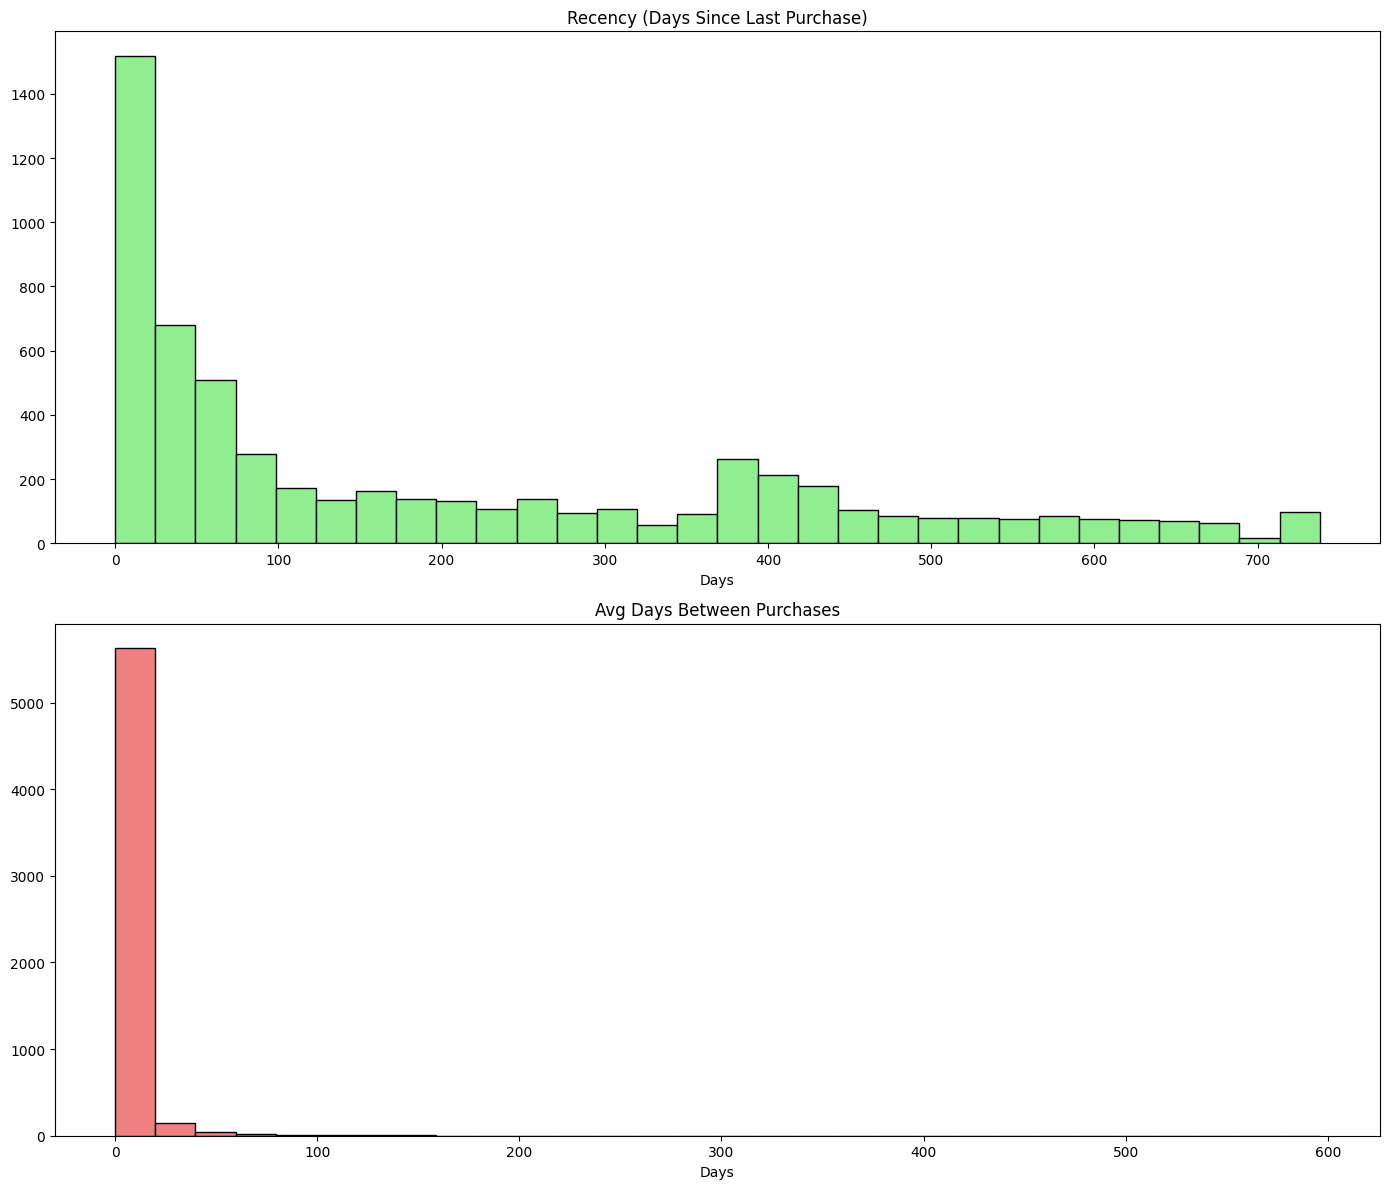

In [78]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

axes[0].hist(customer_data['Recency'], bins=30, color='lightgreen', edgecolor='black')
axes[0].set_title('Recency (Days Since Last Purchase)')
axes[0].set_xlabel('Days')


axes[1].hist(customer_data['Avg_Days_Between_Purchases'], bins=30, color='lightcoral', edgecolor='black')
axes[1].set_title('Avg Days Between Purchases')
axes[1].set_xlabel('Days')

plt.tight_layout()
fig.savefig("../assets/Recency and Avg Days Between Purchases Histograms.png")
plt.show()

The Recency plot suggest that there is two types of customer either dormant or active. Almost 1500 customers are purchasing with 50 days and another movement is near to 350-400 days so this suggests that there are almost 1500 -2000 regular buyers. Next plot shows that the average days between purchase is 0 -5 days but this is for the repeated customers. Need to see percentage of repeated customers next. 

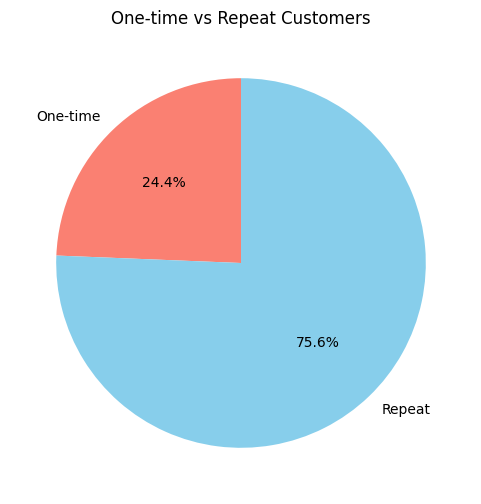

In [79]:
one_time = (customer_data['Frequency'] == 1).sum()
repeat = (customer_data['Frequency'] > 1).sum()

plt.figure(figsize=(6,6))
plt.pie(
    [one_time, repeat],
    labels=['One-time', 'Repeat'],
    autopct='%1.1f%%',
    colors=['salmon', 'skyblue'],
    startangle=90
)
plt.title('One-time vs Repeat Customers')
fig.savefig("../assets/One-time vs Repeat Customers Pie Chart.png")
plt.show()

The pie chart shows that there are almost 75.6 % repeated customers but we need to check whether they are long term customers or 2nd purchase / 3rd purchase. 

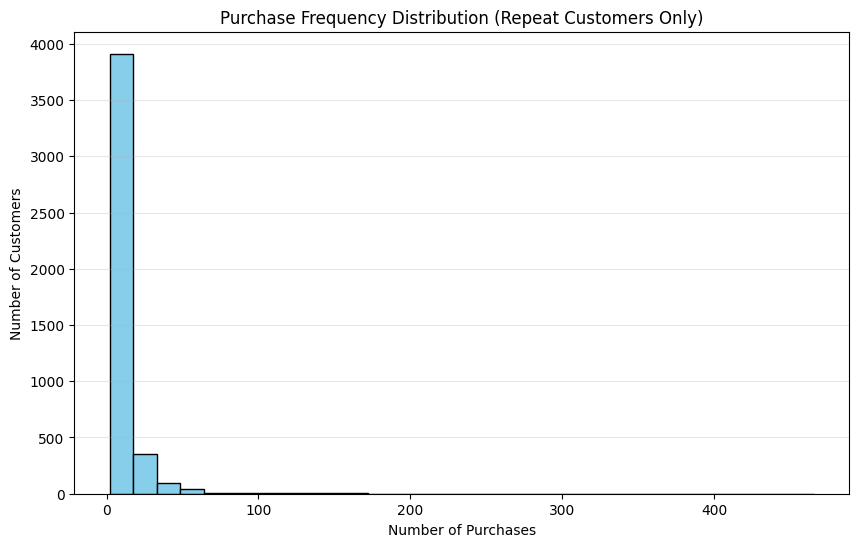

In [80]:

repeat_customers = customer_data[customer_data['Frequency'] > 1]['Frequency']

plt.figure(figsize=(10,6))
plt.hist(repeat_customers, bins=30, color='skyblue', edgecolor='black')
plt.title('Purchase Frequency Distribution (Repeat Customers Only)')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.3)
fig.savefig("../assets/Purchase Frequency Distribution (Repeat Customers Only).png")    
plt.show()

This chart gives us the clear picture. Among the repeated customer most are having exactly 2 purchases and few is having 3 purchases and dramatically it is getting reduced. So Very few customers become highly loyal (10+ purchases). This indicates there is no long term relationship with customers. 

In [81]:
Average_order_value = customer_data.groupby('Customer ID').apply(lambda x: x['Monetary'] / x['Frequency']).mean()
print(f"Average Order Value across all customers: ${Average_order_value:.2f}")

Average Order Value across all customers: $307.29


In [83]:

segments = pd.cut(customer_data['Frequency'], 
                   bins=[0, 1, 2, 3, 5, 10, float('inf')],
                   labels=['One-time', '2 Purchases', '3 Purchases', '4-5 Purchases', '6-10 Purchases', '10+ Purchases'])

print(segments.value_counts().sort_index())



Frequency
One-time          1431
2 Purchases        884
3 Purchases        606
4-5 Purchases      876
6-10 Purchases     995
10+ Purchases     1083
Name: count, dtype: int64


Almost 50 % of the customers are in 1 -3 purchases. 

### Monetary Value Analysis

Lets analyze the Monetary value and will try to answer the below questions. 

    - How is revenue distributed across customers? 
    - What % of revenue comes from top 10% customers? 
    - Are high-value customers frequent or infrequent? 
    - Do a few customers dominate revenue?

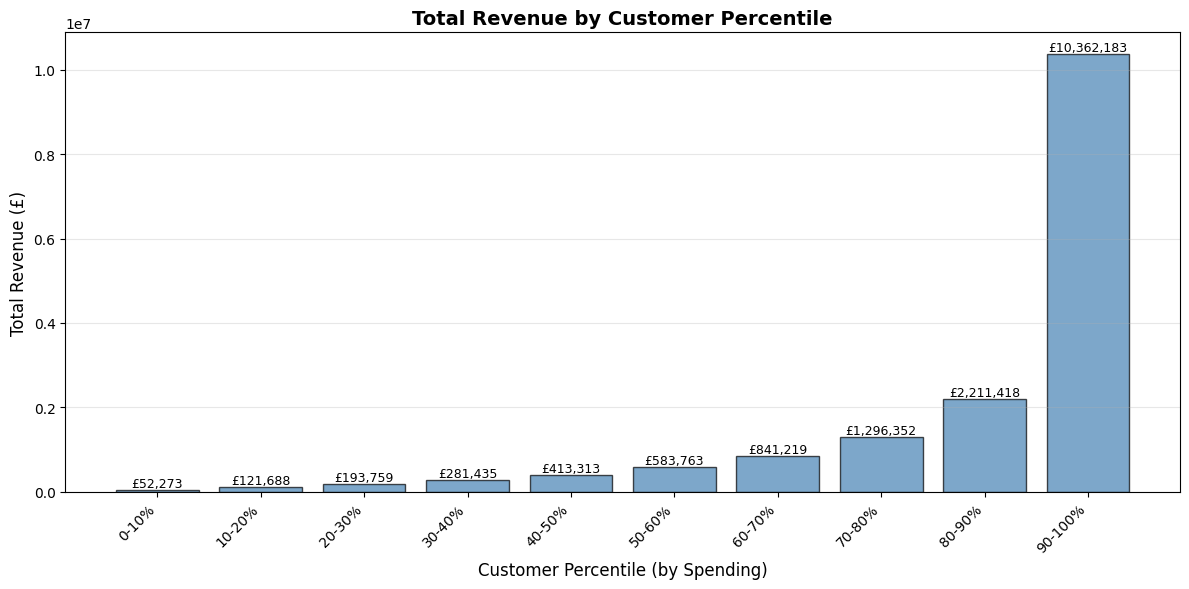

In [84]:


percentile_analysis = customer_data.groupby('Revenue_Percentile', observed=True).agg({
    'Monetary': ['sum', 'mean', 'count']
}).reset_index()

percentile_analysis.columns = ['Percentile', 'Total_Revenue', 'Avg_Revenue', 'Customer_Count']


plt.figure(figsize=(12, 6))
bars = plt.bar(percentile_analysis['Percentile'], 
               percentile_analysis['Total_Revenue'],
               color='steelblue', edgecolor='black', alpha=0.7)

plt.title('Total Revenue by Customer Percentile', fontsize=14, fontweight='bold')
plt.xlabel('Customer Percentile (by Spending)', fontsize=12)
plt.ylabel('Total Revenue (£)', fontsize=12)
plt.grid(axis='y', alpha=0.3)


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'£{height:,.0f}',
            ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
fig.savefig("../assets/Total Revenue by Customer Percentile.png")
plt.show()




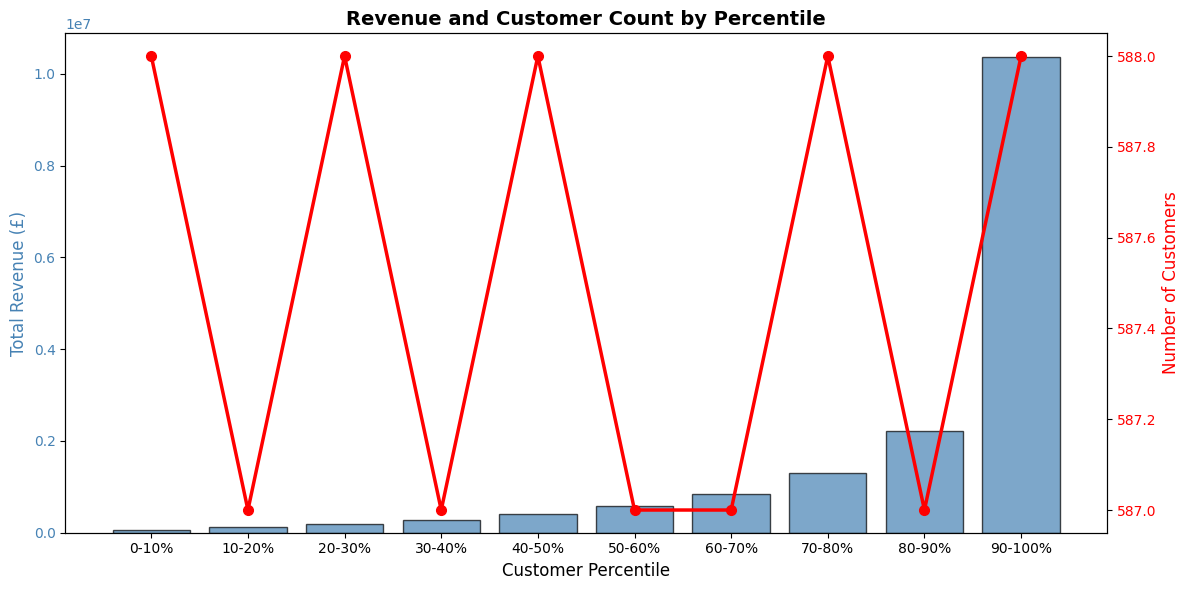

In [85]:
fig, ax1 = plt.subplots(figsize=(12, 6))


bars = ax1.bar(percentile_analysis['Percentile'], 
               percentile_analysis['Total_Revenue'],
               label='Total Revenue', color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Customer Percentile', fontsize=12)
ax1.set_ylabel('Total Revenue (£)', fontsize=12, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')


ax2 = ax1.twinx()
ax2.plot(percentile_analysis['Percentile'], 
         percentile_analysis['Customer_Count'],
         color='red', marker='o', linewidth=2.5, markersize=7, label='Customer Count')
ax2.set_ylabel('Number of Customers', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Revenue and Customer Count by Percentile', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
fig.savefig("../assets/Revenue and Customer Count by Percentile.png")
plt.show()

Below is the breakdown of revenue. 


- 0-80%   customers: £9.3M 
- 80-90%  customers: £1.3M   
- 90-100% customers: £10.4M 


As per the plot the revenue is gradually increasing till 90 % and there is sudden increase in the revenue. Top 10 % contributes almost 50 % of revenue. This is an indication of over reliance on top 10 % and if the top 10% churn then the 50% of revenue is gone. But there lies an opportunity that to understand what makes top 10% different and replicate their characteristics in the 80-90% segment. This is giving massive growth potential. 

### Recency & Inactivity Patterns

Lets check the recency and inactivity patterns and answer the questions below. 

    -   How long since customers last purchased? 
    -   What does the recency distribution look like? 
    -   Is there a natural breakpoints and Does inactivity correlate with lower future spending?

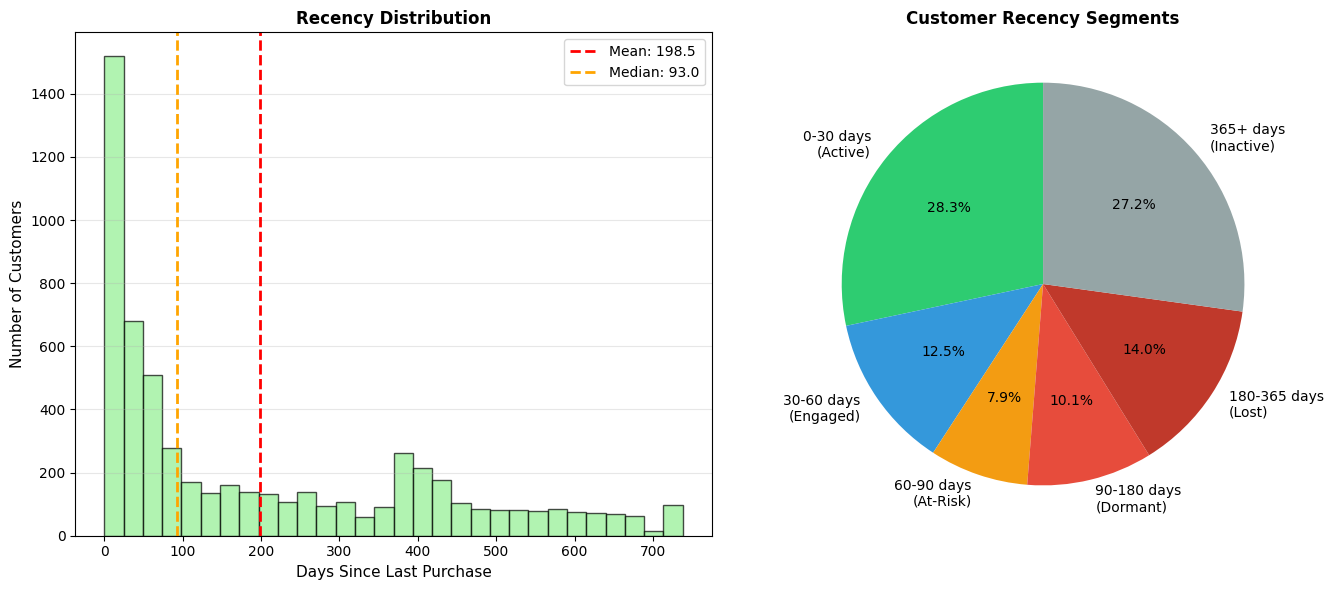

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

mean_recency = customer_data['Recency'].mean()
median_recency = customer_data['Recency'].median()


ax1.hist(customer_data['Recency'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
ax1.axvline(mean_recency, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_recency:.1f}')
ax1.axvline(median_recency, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_recency:.1f}')
ax1.set_title('Recency Distribution', fontsize=12, fontweight='bold')
ax1.set_xlabel('Days Since Last Purchase', fontsize=11)
ax1.set_ylabel('Number of Customers', fontsize=11)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)


recency_segments = pd.cut(customer_data['Recency'], 
                          bins=[0, 30, 60, 90, 180, 365, 1000],
                          labels=['0-30 days\n(Active)', '30-60 days\n(Engaged)', 
                                 '60-90 days\n(At-Risk)', '90-180 days\n(Dormant)',
                                 '180-365 days\n(Lost)', '365+ days\n(Inactive)'])

segment_counts = recency_segments.value_counts().sort_index()
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#c0392b', '#95a5a6']
ax2.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Customer Recency Segments', fontsize=12, fontweight='bold')

plt.tight_layout()
fig.savefig("../assets/Recency Distribution and Segments.png")
plt.show()


This chart gives larger picture. 59.2% of customers are at-risk or lost and Only 40.8% are actively engaged. Different measures need to introduced to recover the lost or at-risk customers. 

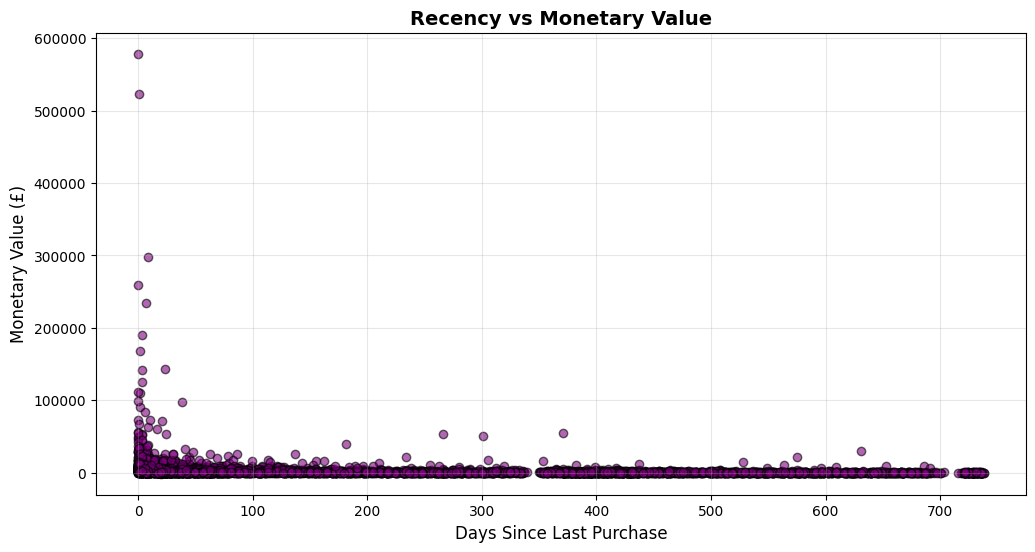

In [87]:
plt.figure(figsize=(12, 6))
plt.scatter(customer_data['Recency'], customer_data['Monetary'], alpha=0.6, color='purple', edgecolor='black')
plt.title('Recency vs Monetary Value', fontsize=14, fontweight='bold')  
plt.xlabel('Days Since Last Purchase', fontsize=12)
plt.ylabel('Monetary Value (£)', fontsize=12)
plt.grid(alpha=0.3)
fig.savefig("../assets/Recency vs Monetary Value Scatter Plot.png")
plt.show()

This is indicating that the top spenders are regularly active and they are buying regularly. We can confirm this only be re-verifying because there is high chance that the top spenders may by one time buyers. Let's verify this. 

In [88]:
top_10_pct = customer_data[customer_data['Monetary'] > customer_data['Monetary'].quantile(0.90)]
mid_tier = customer_data[(customer_data['Monetary'] > customer_data['Monetary'].quantile(0.50)) & 
                         (customer_data['Monetary'] <= customer_data['Monetary'].quantile(0.90))]
bottom_50 = customer_data[customer_data['Monetary'] <= customer_data['Monetary'].quantile(0.50)]


print("\n TOP 10% SPENDERS :")
print(f"   Avg Recency: {top_10_pct['Recency'].mean():.1f} days")
print(f"   Avg Frequency: {top_10_pct['Frequency'].mean():.2f} purchases")
print(f"   Avg Days Between Purchases: {top_10_pct['Avg_Days_Between_Purchases'].mean():.2f} days")
print(f"   Purchase Regularity: {top_10_pct['Purchase_Regularity'].mean():.3f}")
print(f"   % Active (0-30 days): {len(top_10_pct[top_10_pct['Recency'] <= 30])/len(top_10_pct)*100:.1f}%")
print(f"   % Dormant (90+ days): {len(top_10_pct[top_10_pct['Recency'] > 90])/len(top_10_pct)*100:.1f}%")

print("\n MID-TIER SPENDERS :")
print(f"   Avg Recency: {mid_tier['Recency'].mean():.1f} days")
print(f"   Avg Frequency: {mid_tier['Frequency'].mean():.2f} purchases")
print(f"   Avg Days Between Purchases: {mid_tier['Avg_Days_Between_Purchases'].mean():.2f} days")
print(f"   Purchase Regularity: {mid_tier['Purchase_Regularity'].mean():.3f}")
print(f"   % Active (0-30 days): {len(mid_tier[mid_tier['Recency'] <= 30])/len(mid_tier)*100:.1f}%")
print(f"   % Dormant (90+ days): {len(mid_tier[mid_tier['Recency'] > 90])/len(mid_tier)*100:.1f}%")

print("\n  BOTTOM 50% SPENDERS:")
print(f"   Avg Recency: {bottom_50['Recency'].mean():.1f} days")
print(f"   Avg Frequency: {bottom_50['Frequency'].mean():.2f} purchases")
print(f"   Avg Days Between Purchases: {bottom_50['Avg_Days_Between_Purchases'].mean():.2f} days")
print(f"   Purchase Regularity: {bottom_50['Purchase_Regularity'].mean():.3f}")
print(f"   % Active (0-30 days): {len(bottom_50[bottom_50['Recency'] <= 30])/len(bottom_50)*100:.1f}%")
print(f"   % Dormant (90+ days): {len(bottom_50[bottom_50['Recency'] > 90])/len(bottom_50)*100:.1f}%")


 TOP 10% SPENDERS :
   Avg Recency: 46.0 days
   Avg Frequency: 32.60 purchases
   Avg Days Between Purchases: 2.47 days
   Purchase Regularity: 0.166
   % Active (0-30 days): 70.2%
   % Dormant (90+ days): 11.4%

 MID-TIER SPENDERS :
   Avg Recency: 125.0 days
   Avg Frequency: 7.85 purchases
   Avg Days Between Purchases: 5.01 days
   Purchase Regularity: 0.340
   % Active (0-30 days): 37.2%
   % Dormant (90+ days): 37.0%

  BOTTOM 50% SPENDERS:
   Avg Recency: 287.8 days
   Avg Frequency: 2.13 purchases
   Avg Days Between Purchases: 5.93 days
   Purchase Regularity: 1.105
   % Active (0-30 days): 15.4%
   % Dormant (90+ days): 68.8%


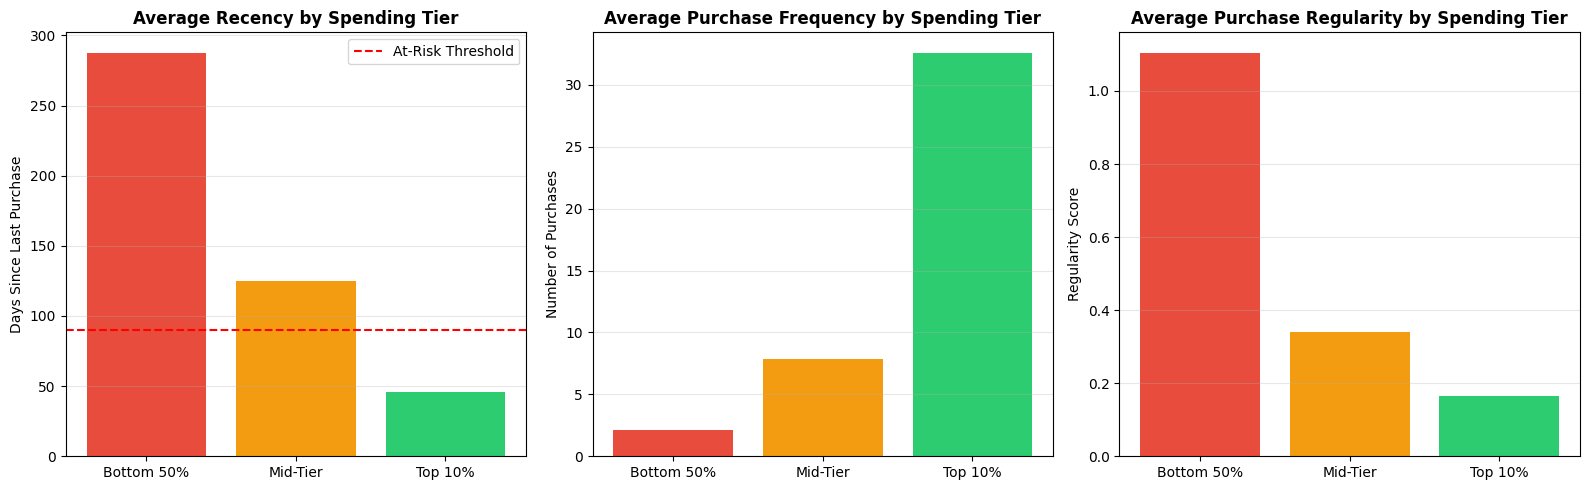

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

tiers = ['Bottom 50%', 'Mid-Tier', 'Top 10%']
recencies = [bottom_50['Recency'].mean(), mid_tier['Recency'].mean(), top_10_pct['Recency'].mean()]
frequencies = [bottom_50['Frequency'].mean(), mid_tier['Frequency'].mean(), top_10_pct['Frequency'].mean()]
regularities = [bottom_50['Purchase_Regularity'].mean(), mid_tier['Purchase_Regularity'].mean(), top_10_pct['Purchase_Regularity'].mean()]

# Recency
axes[0].bar(tiers, recencies, color=['#e74c3c', '#f39c12', '#2ecc71'])
axes[0].set_title('Average Recency by Spending Tier', fontweight='bold')
axes[0].set_ylabel('Days Since Last Purchase')
axes[0].axhline(y=90, color='red', linestyle='--', label='At-Risk Threshold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Frequency
axes[1].bar(tiers, frequencies, color=['#e74c3c', '#f39c12', '#2ecc71'])
axes[1].set_title('Average Purchase Frequency by Spending Tier', fontweight='bold')
axes[1].set_ylabel('Number of Purchases')
axes[1].grid(axis='y', alpha=0.3)

# Regularity
axes[2].bar(tiers, regularities, color=['#e74c3c', '#f39c12', '#2ecc71'])
axes[2].set_title('Average Purchase Regularity by Spending Tier', fontweight='bold')
axes[2].set_ylabel('Regularity Score')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
fig.savefig("../assets/Customer Behavior by Spending Tier.png")
plt.show()

This visuals are confirming that the top 10 % are regular buyers and this also suggests that there is massive growth potential if we are able to convert the bottom 50 % like our top 10%. 

### RFM Segmentation

A way to create customer segments based on their purchases patterns is to perform a RFM (Recency, Frequency, Monetary) analysis. It groups the customers on the basis of their previous purchase transactions. Below are the definitions of each term in RFM:

    - Recency: Time since customer's last transaction

    - Frequency: Total number of transactions

    - Monetary: Total money spend by the customer.

Lets check the RFM Segmentation and answer the questions as below. 


    -   How do customers distribute across R, F, and M? 
    -   Which RFM segments generate the most revenue? 
    -   Are there high-value but low-recency customers? 
    -   Which segments are shrinking over time?

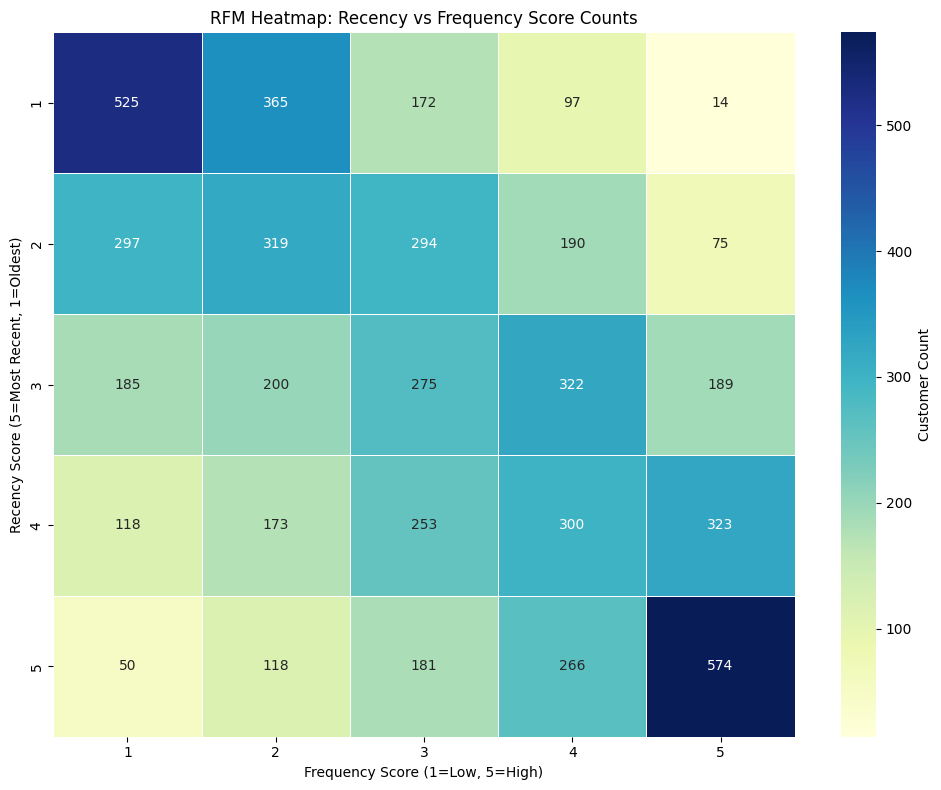

In [90]:



plt.figure(figsize=(10, 8))
rfm_heatmap = customer_data.groupby(['R_Score', 'F_Score']).size().unstack(fill_value=0)
sns.heatmap(rfm_heatmap, annot=True, fmt='d', cmap='YlGnBu', 
            cbar_kws={'label': 'Customer Count'}, linewidths=0.5)
plt.title('RFM Heatmap: Recency vs Frequency Score Counts')
plt.xlabel('Frequency Score (1=Low, 5=High)')
plt.ylabel('Recency Score (5=Most Recent, 1=Oldest)')
plt.tight_layout()
fig.savefig("../assets/RFM Heatmap Recency vs Frequency Score Counts.png")
plt.show()

The heatmap is indicating that around 574 top buying customer are dormant now. Need to find out the reasons why they became in-active and if we are able to return them its a huge advantage. 

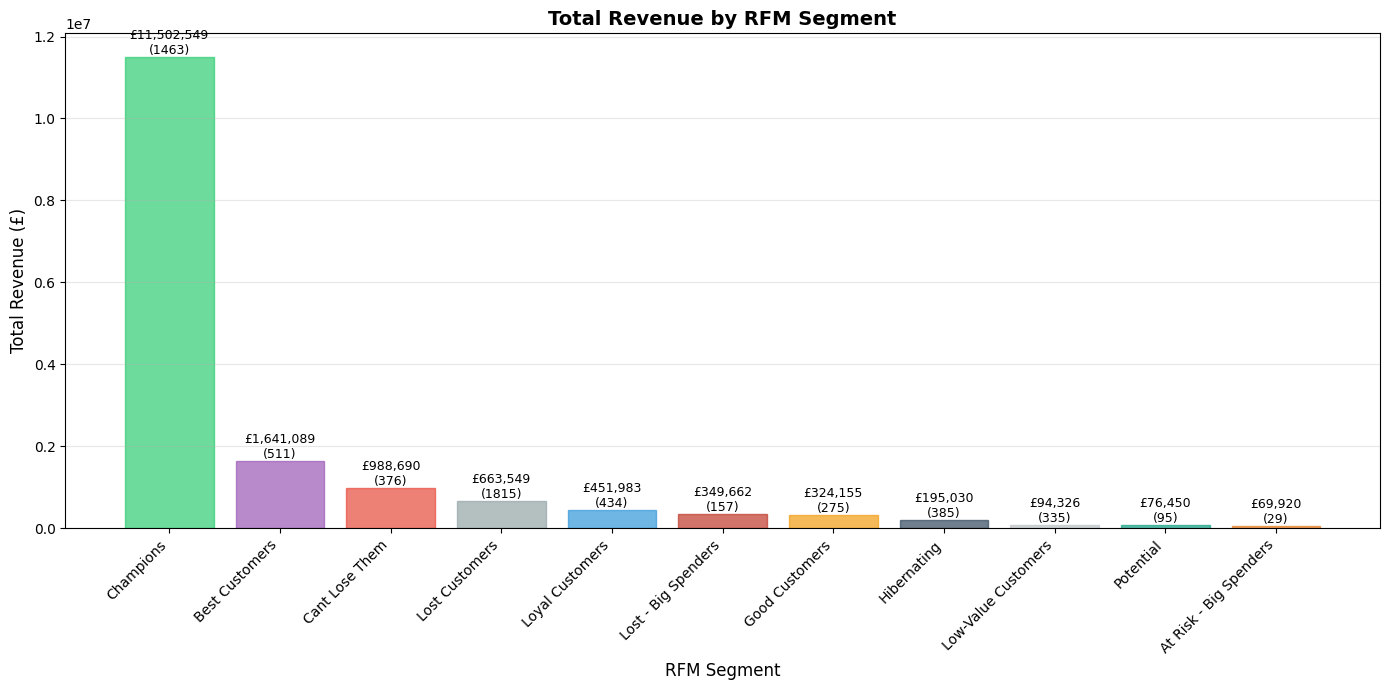

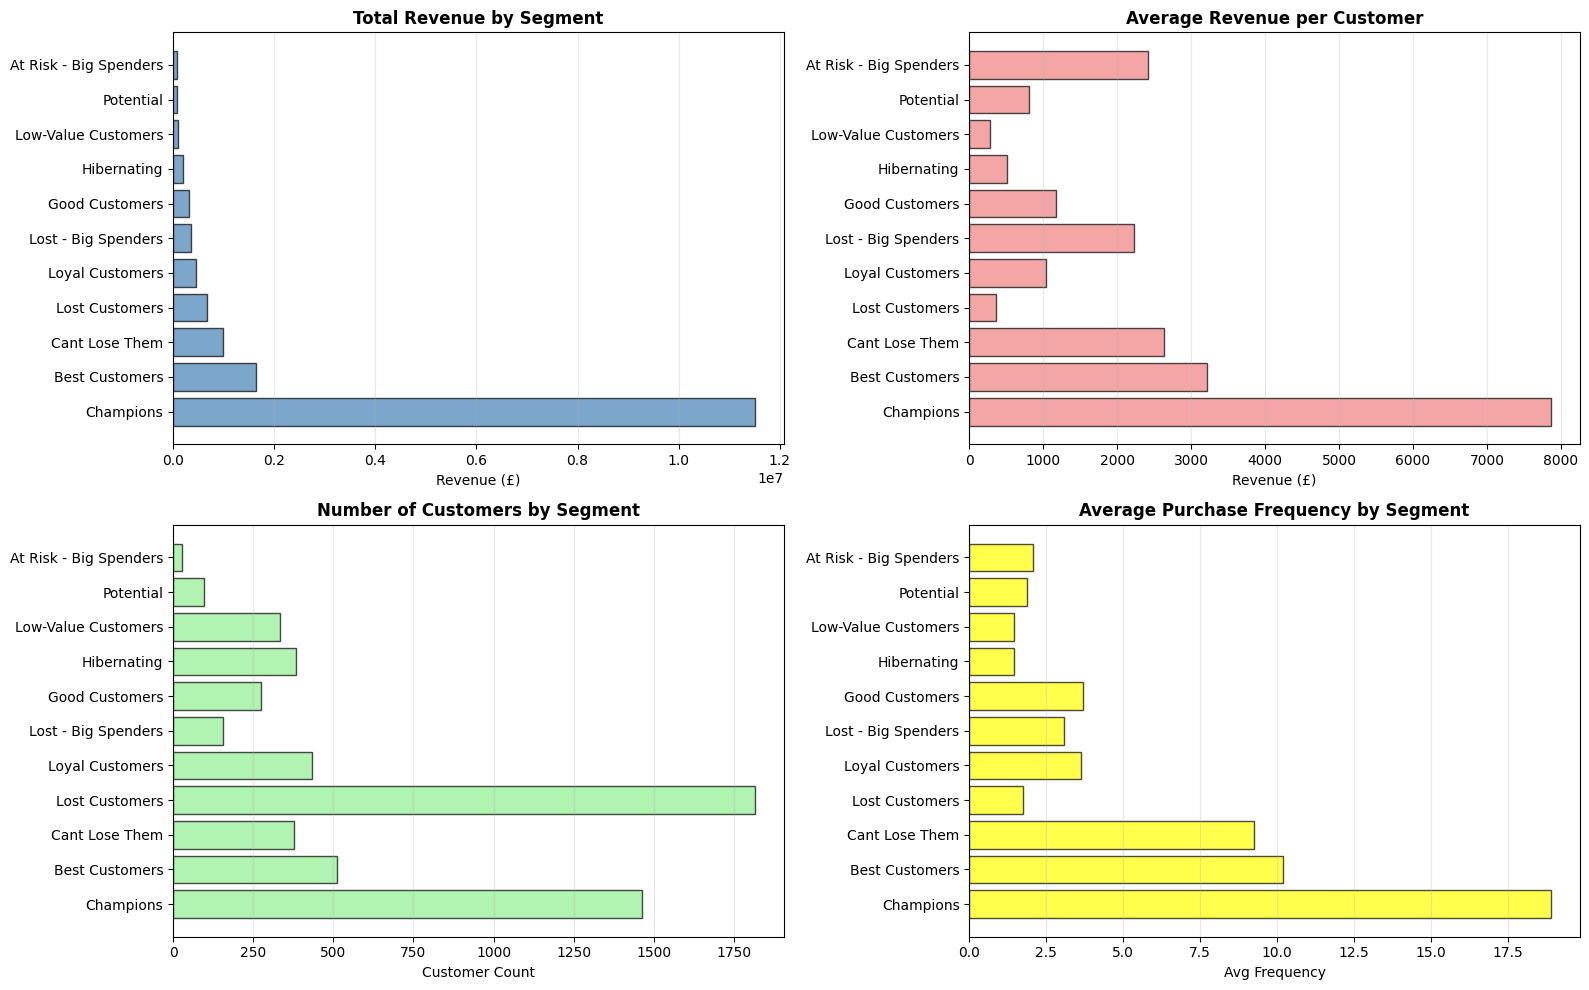

In [91]:


rfm_revenue = customer_data.groupby('RFM_Segment').agg({
    'Monetary': ['sum', 'mean', 'count'],
    'Frequency': 'mean',
    'Recency': 'mean'
}).round(2)

rfm_revenue.columns = ['Total_Revenue', 'Avg_Revenue', 'Customer_Count', 'Avg_Frequency', 'Avg_Recency']
rfm_revenue = rfm_revenue.sort_values('Total_Revenue', ascending=False)

plt.figure(figsize=(14, 7))
bars = plt.bar(range(len(rfm_revenue)), rfm_revenue['Total_Revenue'], 
               color='steelblue', edgecolor='black', alpha=0.7)


colors_map = {
    'Champions': '#2ecc71',
    'Loyal Customers': '#3498db',
    'Best Customers': '#9b59b6',
    'Good Customers': '#f39c12',
    'At Risk - Big Spenders': '#e67e22',
    'Cant Lose Them': '#e74c3c',
    'Lost - Big Spenders': '#c0392b',
    'Lost Customers': '#95a5a6',
    'Hibernating': '#34495e',
    'Low-Value Customers': '#bdc3c7',
    'Potential': '#16a085'
}

for i, (bar, segment) in enumerate(zip(bars, rfm_revenue.index)):
    bar.set_color(colors_map.get(segment, 'steelblue'))

plt.title('Total Revenue by RFM Segment', fontsize=14, fontweight='bold')
plt.xlabel('RFM Segment', fontsize=12)
plt.ylabel('Total Revenue (£)', fontsize=12)
plt.xticks(range(len(rfm_revenue)), rfm_revenue.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)


for i, (bar, value) in enumerate(zip(bars, rfm_revenue['Total_Revenue'])):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
            f'£{value:,.0f}\n({rfm_revenue["Customer_Count"].iloc[i]:.0f})',
            ha='center', va='bottom', fontsize=9)
    

plt.tight_layout()
fig.savefig("../assets/Total Revenue by RFM Segment.png")
plt.show()


fig, axes = plt.subplots(2, 2, figsize=(16, 10))


axes[0, 0].barh(rfm_revenue.index, rfm_revenue['Total_Revenue'], color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Total Revenue by Segment', fontweight='bold')
axes[0, 0].set_xlabel('Revenue (£)')
axes[0, 0].grid(axis='x', alpha=0.3)


axes[0, 1].barh(rfm_revenue.index, rfm_revenue['Avg_Revenue'], color='lightcoral', edgecolor='black',alpha=0.7)
axes[0, 1].set_title('Average Revenue per Customer', fontweight='bold')
axes[0, 1].set_xlabel('Revenue (£)')
axes[0, 1].grid(axis='x', alpha=0.3)


axes[1, 0].barh(rfm_revenue.index, rfm_revenue['Customer_Count'], color='lightgreen', edgecolor='black',alpha=0.7)
axes[1, 0].set_title('Number of Customers by Segment', fontweight='bold')
axes[1, 0].set_xlabel('Customer Count')
axes[1, 0].grid(axis='x', alpha=0.3)


axes[1, 1].barh(rfm_revenue.index, rfm_revenue['Avg_Frequency'], color='yellow', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Average Purchase Frequency by Segment', fontweight='bold')
axes[1, 1].set_xlabel('Avg Frequency')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
fig.savefig("../assets/RFM Segment Analysis.png")
plt.show()



These charts are indicating that the same problem. Champions - Customer is running the show and the business are very much dependent on them. Need to bring back the lost top buyers. Need to develop different strategy for each customer type. 

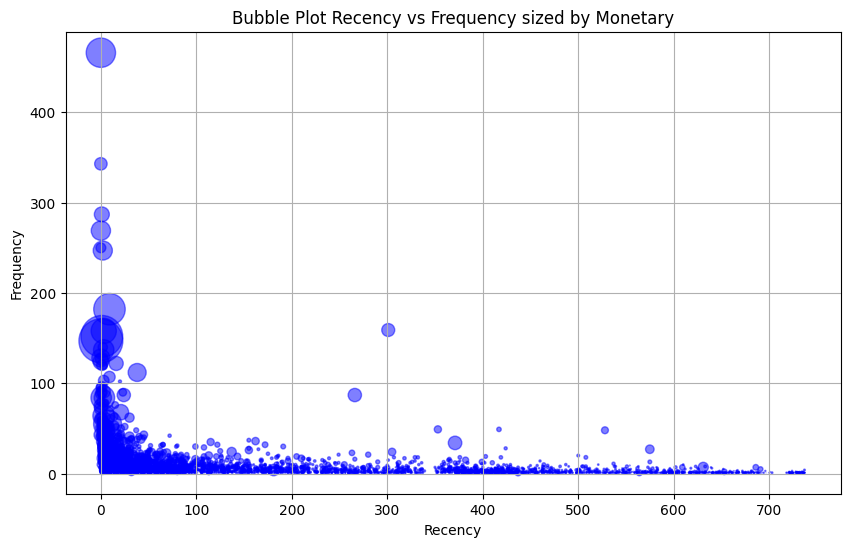

In [92]:


plt.figure(figsize=(10, 6))
monetary = customer_data['Monetary'].clip(lower=0)
bubble_sizes = monetary / monetary.max() * 1000
plt.scatter(customer_data['Recency'], customer_data['Frequency'], s=bubble_sizes, alpha=0.5, c='blue')
plt.title('Bubble Plot Recency vs Frequency sized by Monetary')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.grid(True)
fig.savefig("../assets/Bubble Plot Recency vs Frequency sized by Monetary.png")
plt.show()

This plot is indicating that we are losing customer and is facing  retention crisis. 

### Behavioral Stability (RSS) Analysis

Lets check the Behavioral Stability (RSS) Analysis and answer the below questions. 

    -   Do customers spend consistently or erratically? 
    -   Is spending increasing or decreasing over time? 
    -   How variable are purchase intervals? 
    -   Which segments show declining engagement trends?

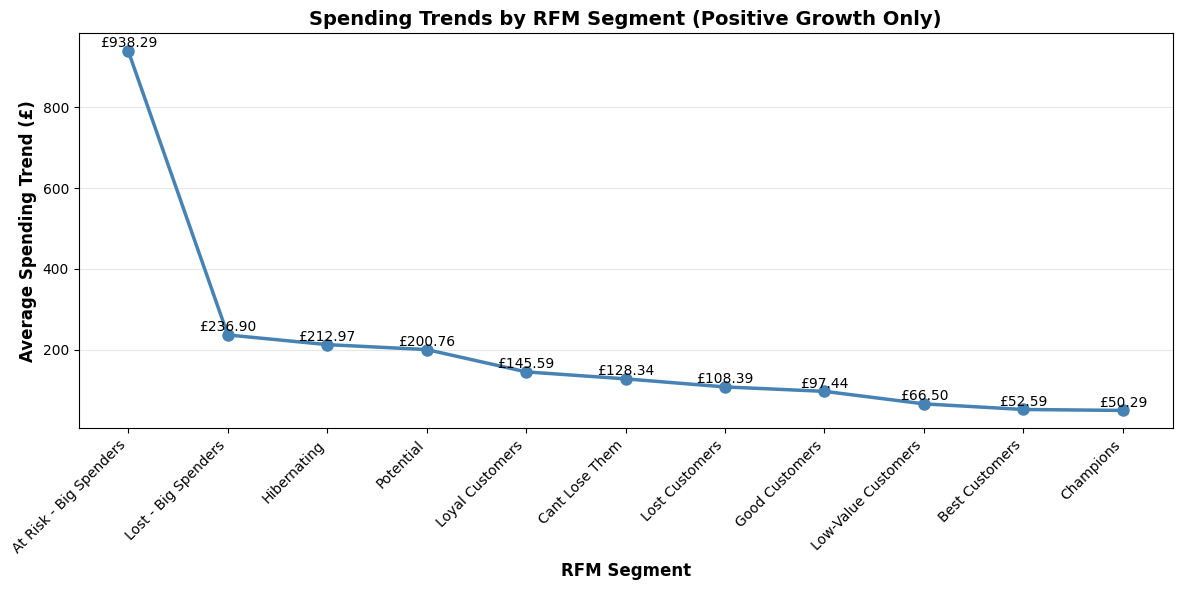

In [93]:
positive_data = customer_data[customer_data['Spending_Trend'] > 0]
RFM_Segment_Data = positive_data.groupby('RFM_Segment')['Spending_Trend'].mean()


RFM_Segment_Data = RFM_Segment_Data.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.plot(RFM_Segment_Data.index, RFM_Segment_Data.values, 
         marker='o', linestyle='-', linewidth=2.5, markersize=8, color='steelblue')


for i, (segment, value) in enumerate(RFM_Segment_Data.items()):
    plt.text(i, value + 2, f'£{value:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('RFM Segment', fontsize=12, fontweight='bold')
plt.ylabel('Average Spending Trend (£)', fontsize=12, fontweight='bold')
plt.title('Spending Trends by RFM Segment (Positive Growth Only)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
fig.savefig("../assets/Spending Trends by RFM Segment (Positive Growth Only).png")
plt.show()

This plot is indicating best customers aren't growing their spending. At-risk customers are spiking in spending that might be the big purchase before they churn. 

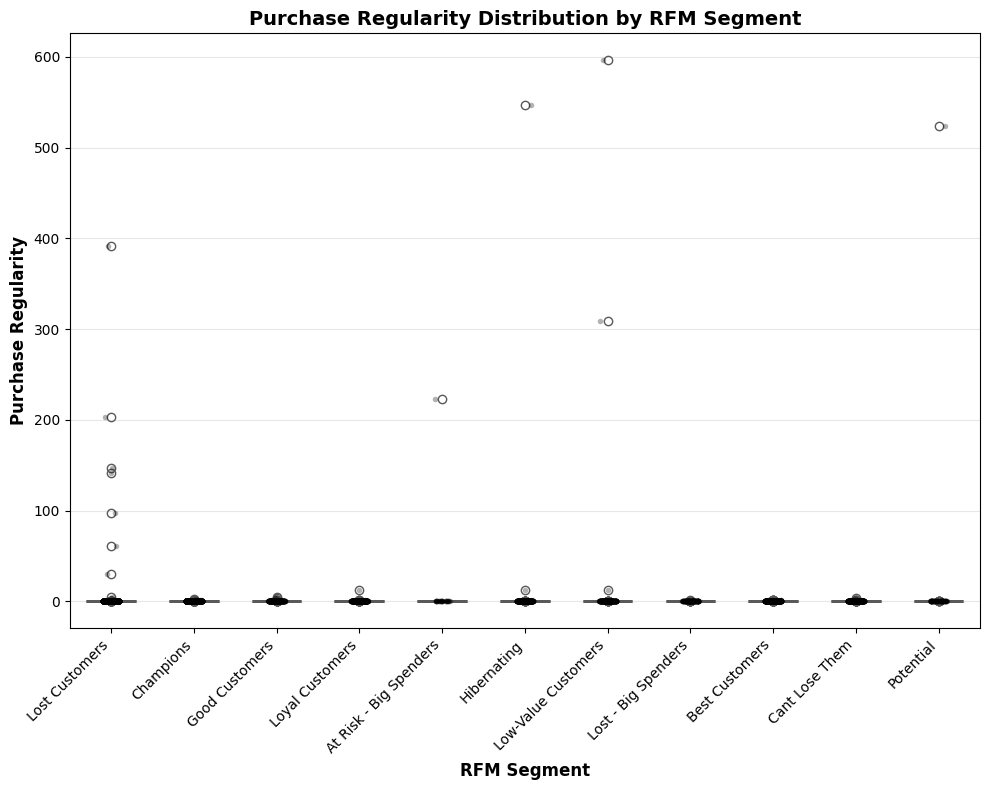

In [94]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(data=customer_data, x='RFM_Segment', y='Purchase_Regularity', 
                 palette='Set2',hue='RFM_Segment', linewidth=2, width=0.6)
sns.stripplot(data=customer_data, x='RFM_Segment', y='Purchase_Regularity', 
              color='black', alpha=0.3, size=4, jitter=True)

plt.title('Purchase Regularity Distribution by RFM Segment', 
          fontsize=14, fontweight='bold')
plt.xlabel('RFM Segment', fontsize=12, fontweight='bold')
plt.ylabel('Purchase Regularity', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
fig.savefig("../assets/Purchase Regularity Distribution by RFM Segment.png")
plt.show()

This plot shows that  even though the champions are regular buyers and active but it is difficult to predict the exact timing of purchase. Champions are amazing customers but cannot manage them blind because can't predict their behavior.

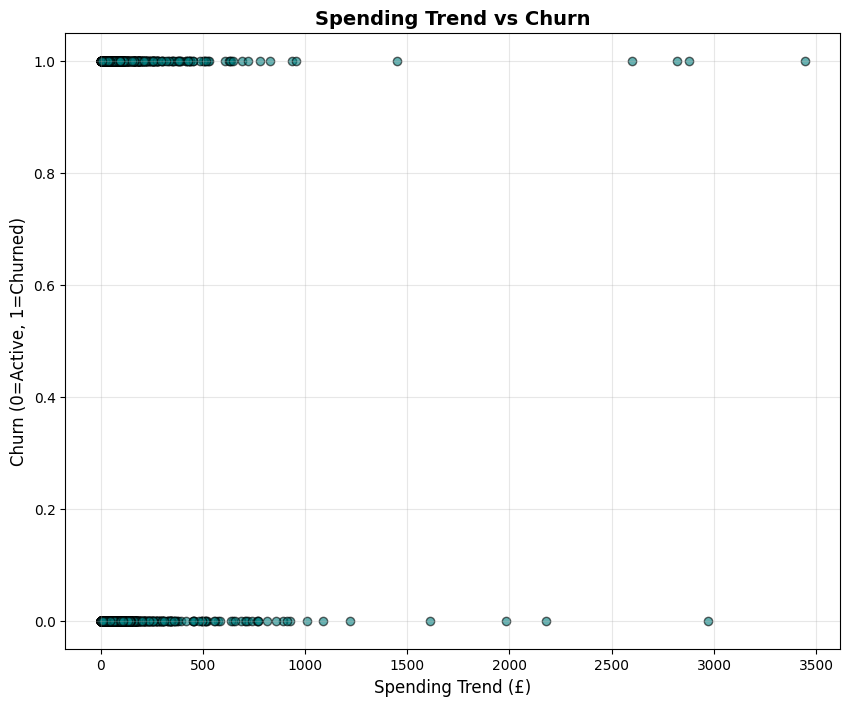

In [95]:
plt.figure(figsize=(10,8))
plt.scatter(positive_data['Spending_Trend'],positive_data['Churn'],alpha=0.6,color='teal',edgecolor='black')
plt.title('Spending Trend vs Churn', fontsize=14, fontweight='bold')
plt.xlabel('Spending Trend (£)', fontsize=12)
plt.ylabel('Churn (0=Active, 1=Churned)', fontsize=12)
plt.grid(alpha=0.3)
fig.savefig("../assets/Spending Trend vs Churn Scatter Plot.png")
plt.show()

The churn problem is not much related to spending. The spending trend range is identical and there is no correlation. 

### Churn Label Exploration (Before Modeling)


Lets analyze the churn and answer the below questions. 

    -   What % of customers are labeled as churned? 
    -   How does churn vary across RFM segments? 
    -   Are high-value customers churning less or more? 


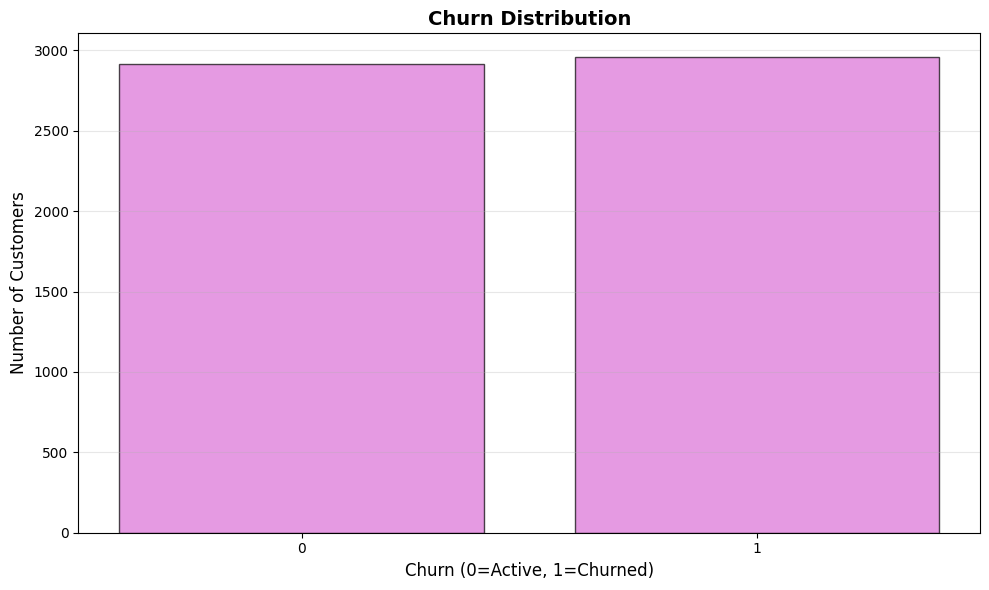

In [99]:
churn_counts = customer_data['Churn'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(churn_counts.index.astype(str), churn_counts.values,color='orchid', edgecolor='black', alpha=0.7)
plt.title('Churn Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn (0=Active, 1=Churned)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
fig.savefig("../assets/Churn Distribution.png")
plt.show()


More that 50 % of customers have churned overall. Many low-engagement customers churn and few Champions churn

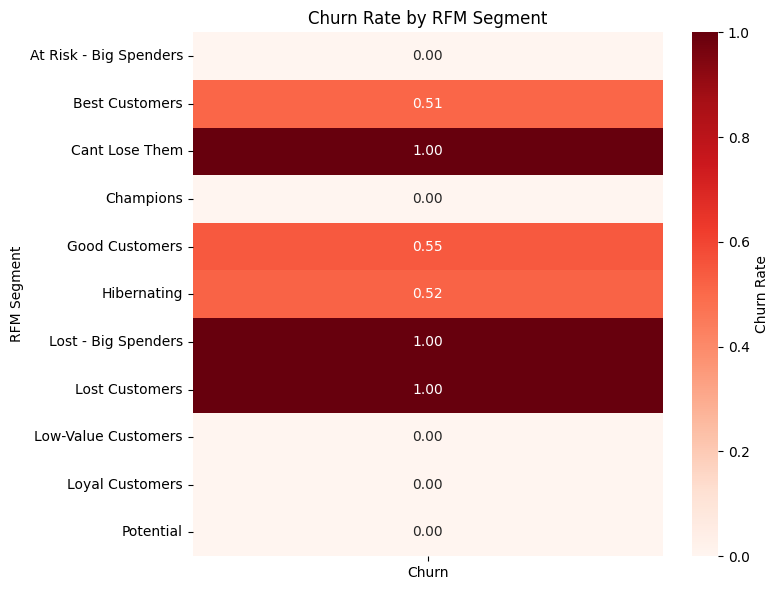

In [100]:
segment_churn = (
    customer_data
    .groupby('RFM_Segment')['Churn']
    .mean()                      
    .reset_index()
)


segment_churn = segment_churn.sort_values('Churn', ascending=False)


pivot_churn = segment_churn.pivot_table(
    index='RFM_Segment',
    values='Churn'
)


plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot_churn,
    annot=True,
    fmt=".2f",
    cmap='Reds',
    cbar_kws={'label': 'Churn Rate'}
)
plt.title('Churn Rate by RFM Segment')
plt.xlabel('')
plt.ylabel('RFM Segment')
plt.tight_layout()
fig.savefig("../assets/Churn Rate by RFM Segment Heatmap.png")
plt.show()

As expected the Champions have perfect 0% retention. Need to work on Best, Good and Hibernating customers. 

### Segment × Churn × Value Matrix

In this key section we need to answer the below questions. 

    -   Which segments have high churn and high value? 
    -   Which segments have low churn but low value? 
    -   Where should retention budget be spent? 


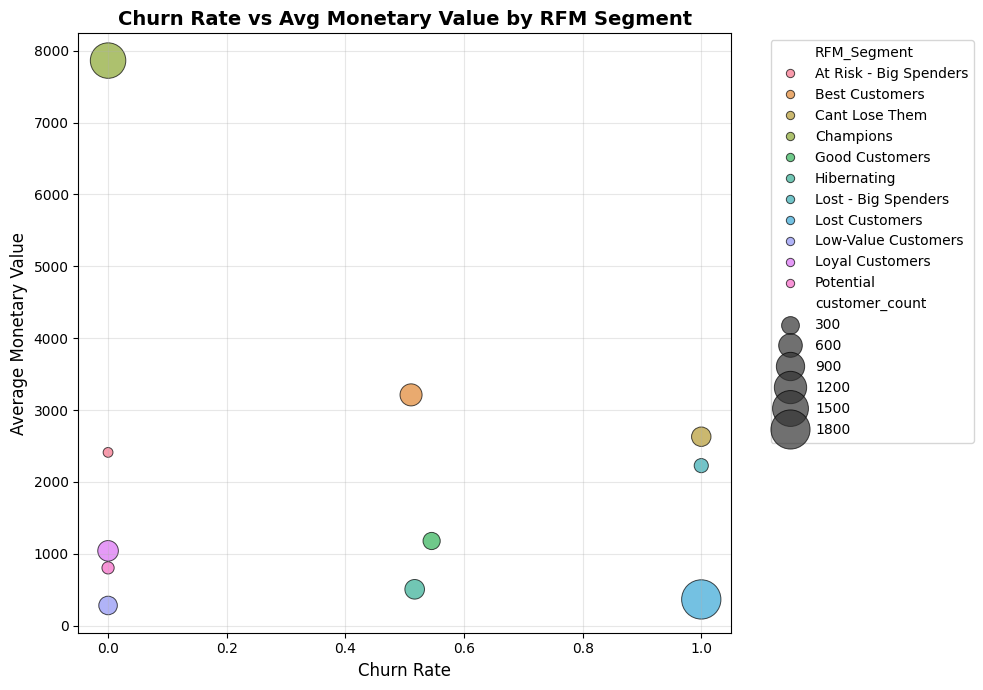

In [101]:
segment_stats = (
    customer_data
    .groupby('RFM_Segment')
    .agg(
        churn_rate = ('Churn', 'mean'),         
        avg_monetary = ('Monetary', 'mean'),    
        customer_count = ('Customer ID', 'nunique')   
    )
    .reset_index()
)


plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=segment_stats,
    x='churn_rate',
    y='avg_monetary',
    size='customer_count',
    sizes=(50, 800),        
    hue='RFM_Segment',    
    alpha=0.7,
    edgecolor='black'
)

plt.title('Churn Rate vs Avg Monetary Value by RFM Segment', fontsize=14, fontweight='bold')
plt.xlabel('Churn Rate', fontsize=12)
plt.ylabel('Average Monetary Value', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
fig.savefig("../assets/Churn Rate vs Avg Monetary Value by RFM Segment Bubble Plot.png")
plt.show()

This plot is indicating that the there is conversation threshold not a retention problem. 

In [102]:
print("\nRFM SEGMENT ANALYSIS - DETAILED REPORT")
print("="*100)
print(rfm_revenue.to_string())


RFM SEGMENT ANALYSIS - DETAILED REPORT
                        Total_Revenue  Avg_Revenue  Customer_Count  Avg_Frequency  Avg_Recency
RFM_Segment                                                                                   
Champions                 11502549.24      7862.30            1463          18.89        18.06
Best Customers             1641088.79      3211.52             511          10.19       102.54
Cant Lose Them              988690.31      2629.50             376           9.26       347.79
Lost Customers              663548.81       365.59            1815           1.75       443.71
Loyal Customers             451982.98      1041.44             434           3.63        23.08
Lost - Big Spenders         349662.26      2227.15             157           3.08       381.72
Good Customers              324154.63      1178.74             275           3.68       107.75
Hibernating                 195029.78       506.57             385           1.46       103.99
Low-Value 

### Actionable Business Decisions

Below are the strategy to be followed 

In [103]:
recommendations_data = {
    'RFM Segment': rfm_revenue.index,
    'Customers': rfm_revenue['Customer_Count'].astype(int),
    'Revenue': rfm_revenue['Total_Revenue'].apply(lambda x: f'£{x:,.0f}'),
    'Strategy': [
        'VIP treatment, loyalty rewards, exclusive offers',
        'Premium support, early access to new products',
        'High-value focus, personalized service',
        'Upsell opportunities, cross-selling',
        'Win-back campaigns, special incentives',
        'Immediate re-engagement, special offers',
        'Aggressive win-back campaign',
        'Low priority, automated campaigns only',
        'Budget-friendly reactivation offers',
        'Convert to higher-value segment',
        'Cross-sell and upsell strategies'
    ]
}


df_recommendations = pd.DataFrame(recommendations_data)


print("\n" + "="*100)
print("RFM SEGMENT RECOMMENDATIONS - STRATEGIC ACTION PLAN")
print("="*100)
print(df_recommendations.to_string(index=False))
print("="*100)


RFM SEGMENT RECOMMENDATIONS - STRATEGIC ACTION PLAN
           RFM Segment  Customers     Revenue                                         Strategy
             Champions       1463 £11,502,549 VIP treatment, loyalty rewards, exclusive offers
        Best Customers        511  £1,641,089    Premium support, early access to new products
        Cant Lose Them        376    £988,690           High-value focus, personalized service
        Lost Customers       1815    £663,549              Upsell opportunities, cross-selling
       Loyal Customers        434    £451,983           Win-back campaigns, special incentives
   Lost - Big Spenders        157    £349,662          Immediate re-engagement, special offers
        Good Customers        275    £324,155                     Aggressive win-back campaign
           Hibernating        385    £195,030           Low priority, automated campaigns only
   Low-Value Customers        335     £94,326              Budget-friendly reactivation offe

## Saving the dataset for Prediction Model 

In [104]:
customer_data.drop(['Churn'], axis=1, inplace=True)
customer_data.to_csv('../research/customer_data.csv', index=False)

## Conclusion 

The business is totally depended on top most best customers and it is failing to convert the 75% of other tier customers and that is resulting in more than 50 % churn rate. The actual problem is the conversion rate and not retention. In order to recover below Four strategic initiatives are recommended. 

- Make the top most best customers happy by VIP programs. 
- Recover the dormant customer who was previously the top most best customers through win-back campaigns 
- Fix conversion pipeline for Best/Good customers
- Implement visibility system to predict churn 

We shall explore the churn prediction model in the next notebook. 